In [58]:
import healpy as h
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))
sys.path.append(os.path.abspath('/Users/adityarotti/Documents/Work/core_codes/generate_apodized_mask/'))
from modules.settings import global_mmf_settings as gset
from modules.data_preprocess import preprocess_planck_data as ppd
from modules.masking import gen_masks
from modules.master import binned_master as bm
from astropy.io import fits
from copy import copy,deepcopy
import pymain as gen_apo_mask
%pylab notebook

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
result_path="../../results/yy_spec/" ; ensure_dir(result_path)
datapath="/Users/adityarotti/Documents/Work/Data/Planck/"

Populating the interactive namespace from numpy and matplotlib


# Initialising the analysis

In [59]:
dataset="planck_pr3"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"

figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False

figstamp,dir_suffix

outpath="/results/" + dataset + "/planck_cosmo_cat_" + dir_suffix + "/"
tempdatapath="/tempdata/" + dataset + "/planck_cosmo_cat/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=10.,do_band_pass=True,use_psf_data=use_psf_data)

In [60]:
do_dgrade=True ; nsideout=2048
lmax=1500
masklmax=2*nsideout
snr_cutoff=6.
apowidth=30. # arcminutes
lf_ps_mask=False

dirname="snr"+str(int(snr_cutoff)) + "_lmax" + str(int(lmax)) + "_mlmax" + str(int(masklmax)) 
dirname=dirname + "_apow" + str(int(apowidth))
if lf_ps_mask:
    dirname=dirname + "_lfpsT"
else:
    dirname=dirname + "_lfpsF"
print dirname

figpath=result_path + "/" + dirname + "/figs/"  ; ensure_dir(figpath)
dataout_path=result_path + "/" + dirname + "/data/"   ; ensure_dir(dataout_path)

snr6_lmax1500_mlmax4096_apow30_lfpsF


In [215]:
figpath

'../../results/yy_spec//snr6_lmax1500_mlmax4096_apow30_lfpsF/figs/'

# Reading in the MMF3 catalogue

In [64]:
mmf3=ppd.get_mmf3_catalogue(zknown=False,snrthr=6.,cosmo_flag=True)
mmf3=ppd.eval_M500_T500_theta500(mmf3)
median_theta500=median(mmf3["theta500"][mmf3["REDSHIFT"]>0])
mmf3["theta500"][[mmf3["REDSHIFT"]<0]]=median_theta500
shape(mmf3["REDSHIFT"])

(549,)

In [77]:
mmf3={}

for qcut in [3,6,9,12,20]:
    mmf3[qcut]=ppd.get_mmf3_catalogue(zknown=False,snrthr=qcut,cosmo_flag=True)

<IPython.core.display.Javascript object>


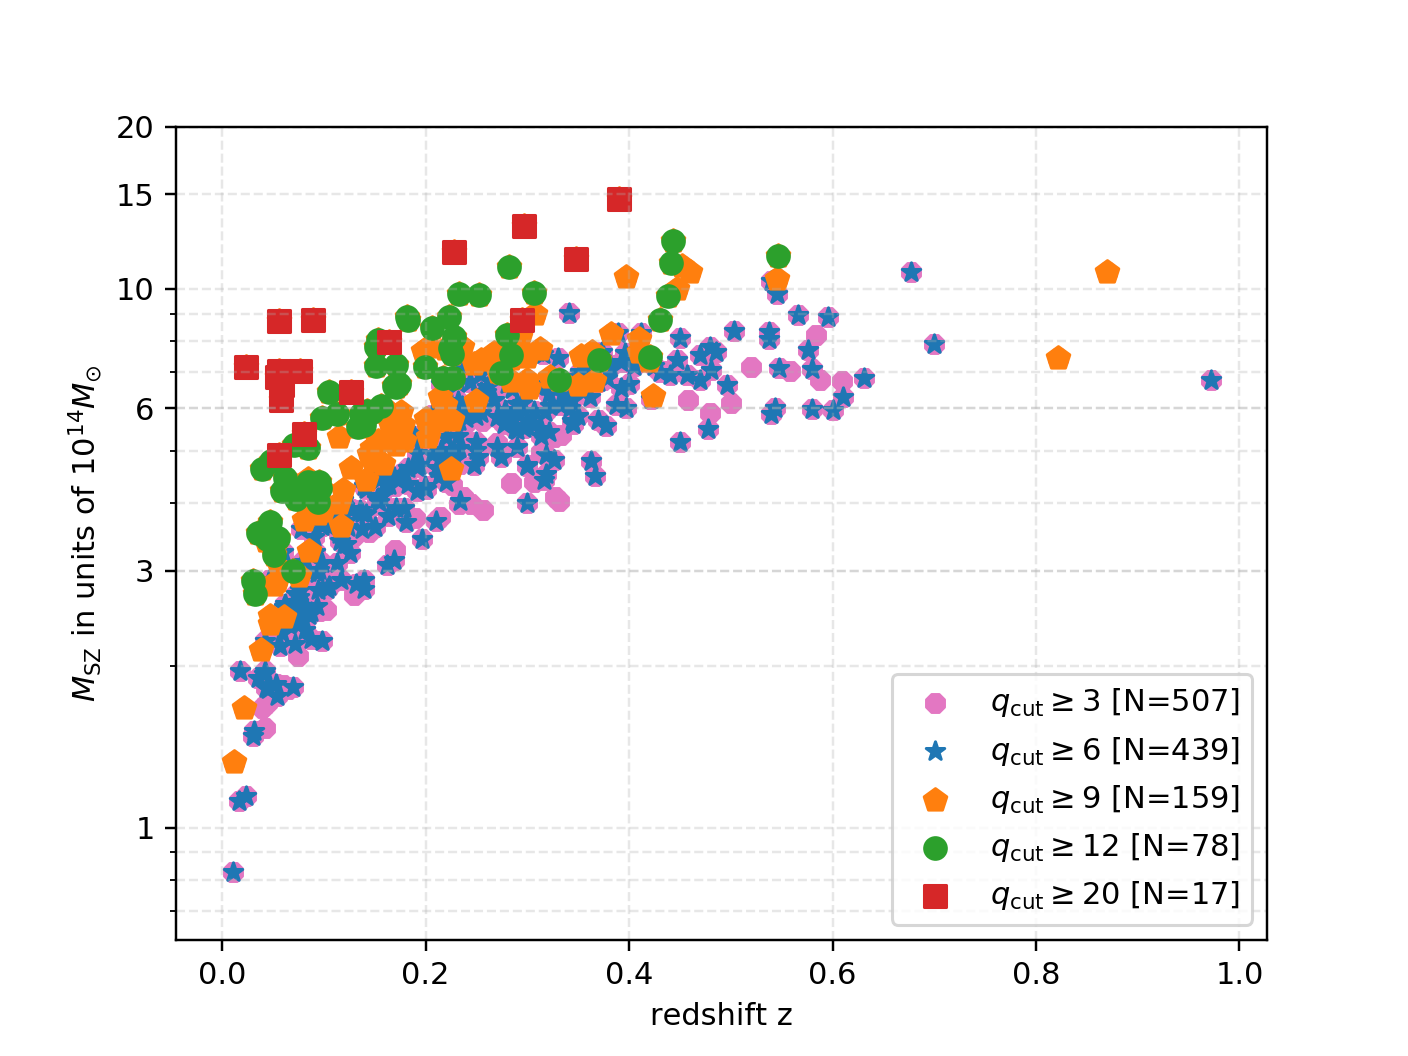

In [91]:
mt={} ; mt[3]="8" ; mt[6]="*" ; mt[9]="p" ; mt[12]="o" ; mt[20]="s"
ms={} ; ms[3]=40 ; ms[6]=40 ; ms[9]=60 ; ms[12]=50 ; ms[20]=50
mc={} ; mc[3]="tab:pink" ; mc[6]="tab:blue" ; mc[9]="tab:orange" ; mc[12]="tab:green" ; mc[20]="tab:red"
figure()
for qcut in [3,6,9,12,20]:
    scatter(mmf3[qcut]["REDSHIFT"][mmf3[qcut]["REDSHIFT"]>=0],mmf3[qcut]["MSZ"][mmf3[qcut]["REDSHIFT"]>=0],marker=mt[qcut],s=ms[qcut],
            label=r"$q_{\rm cut} \geq$" + str(qcut) + " [N=" + str(len(mmf3[qcut]["REDSHIFT"])) +"]",color=mc[qcut])
semilogy()
xlabel("redshift z")
ylabel(r"$M_{\rm SZ}$ in units of" + " $10^{14} M_{\odot}$")
yticks([1,3,6,10,15,20],[1,3,6,10,15,20])
legend(loc=0)
grid(which="both",linestyle="dashed",alpha=0.3)
figname="../../results/yy_spec/sz_m_z_qcut.pdf"
savefig(figname, bbox_inches="tight",dpi=200)

In [267]:
tot=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_psmask/data/total_yy_spec.txt")
tot_g40=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal40_psmask/data/total_yy_spec.txt")
tot_g30=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal30_psmask/data/total_yy_spec.txt")
tot_g60=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal60_psmask/data/total_yy_spec.txt")

urc3=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
urc3_g40=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal40_psmask/data/unresolved_yy_spec.txt")
urc3_g30=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal30_psmask/data/unresolved_yy_spec.txt")
urc3_g60=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal60_psmask/data/unresolved_yy_spec.txt")
urc6=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
urc9=loadtxt("../../results/yy_spec/snr9_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
urc12=loadtxt("../../results/yy_spec/snr12_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
urc20=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
urc20_g40=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_gal40_psmask/data/unresolved_yy_spec.txt")
urc20_g60=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_gal60_psmask/data/unresolved_yy_spec.txt")

rc3=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
rc3_g40=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal40_psmask/data/resolved_yy_spec.txt")
rc3_g30=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal30_psmask/data/resolved_yy_spec.txt")
rc3_g60=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal60_psmask/data/resolved_yy_spec.txt")
rc6=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
rc9=loadtxt("../../results/yy_spec/snr9_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
rc12=loadtxt("../../results/yy_spec/snr12_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
rc20=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
rc20_g40=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_gal40_psmask/data/resolved_yy_spec.txt")
rc20_g30=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_gal30_psmask/data/resolved_yy_spec.txt")
rc20_g60=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_gal60_psmask/data/resolved_yy_spec.txt")

In [280]:
data=loadtxt("../../tempdata/diffuse-rotti++20_step_3_bf_szpowerspectrum.txt")

<IPython.core.display.Javascript object>


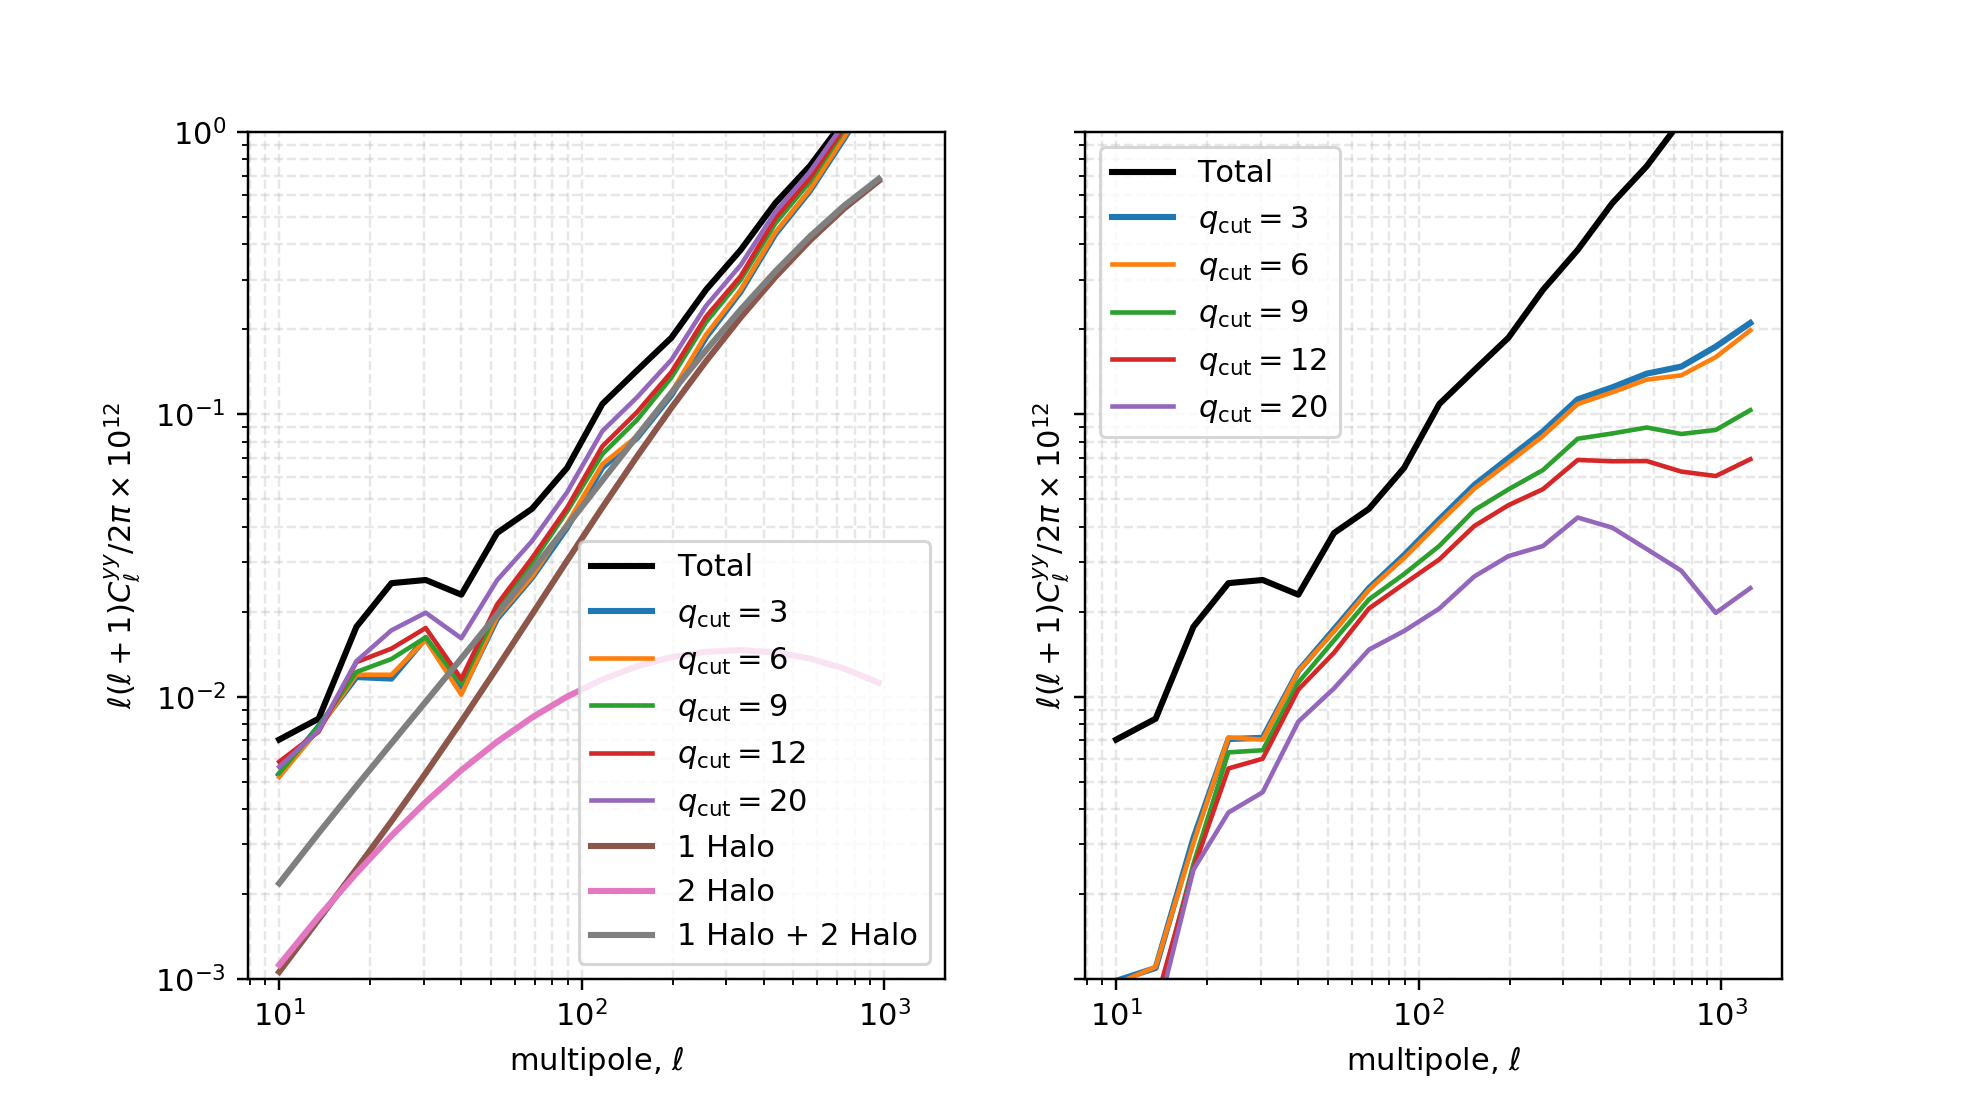

In [291]:
fig,ax=subplots(nrows=1,ncols=2,sharey=True,figsize=(9,5))
ax[0].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total")
ax[0].plot(urc3[:,2],urc3[:,3],lw=2,label=r"$q_{\rm cut}=3$")
ax[0].plot(urc6[:,2],urc6[:,3],label=r"$q_{\rm cut}=6$")
ax[0].plot(urc9[:,2],urc9[:,3],label=r"$q_{\rm cut}=9$")
ax[0].plot(urc12[:,2],urc12[:,3],label=r"$q_{\rm cut}=12$")
ax[0].plot(urc20[:,2],urc20[:,3],label=r"$q_{\rm cut}=20$")
ax[0].loglog()
ax[0].set_ylim(1e-3,1)
ax[0].grid(which="both",alpha=0.3,linestyle="dashed")
ax[0].set_xlabel("multipole, $\ell$")
ax[0].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")
ax[0].plot(data[:,0],data[:,1],lw=2,label="1 Halo")
ax[0].plot(data[:,0],data[:,6],lw=2,label="2 Halo")
ax[0].plot(data[:,0],data[:,6]+data[:,1],lw=2,label="1 Halo + 2 Halo")
ax[0].legend(loc=0)
ax[1].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total")
ax[1].plot(rc3[:,2],rc3[:,3],lw=2,label=r"$q_{\rm cut}=3$")
ax[1].plot(rc6[:,2],rc6[:,3],label=r"$q_{\rm cut}=6$")
ax[1].plot(rc9[:,2],rc9[:,3],label=r"$q_{\rm cut}=9$")
ax[1].plot(rc12[:,2],rc12[:,3],label=r"$q_{\rm cut}=12$")
ax[1].plot(rc20[:,2],rc20[:,3],label=r"$q_{\rm cut}=20$")
ax[1].loglog()
ax[1].grid(which="both",alpha=0.3,linestyle="dashed")
ax[1].legend(loc=0)
ax[1].set_xlabel("multipole, $\ell$")
ax[1].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")

figname="../../results/yy_spec/all_qcut_gal50.pdf"
savefig(figname, bbox_inches="tight",dpi=200)

<IPython.core.display.Javascript object>


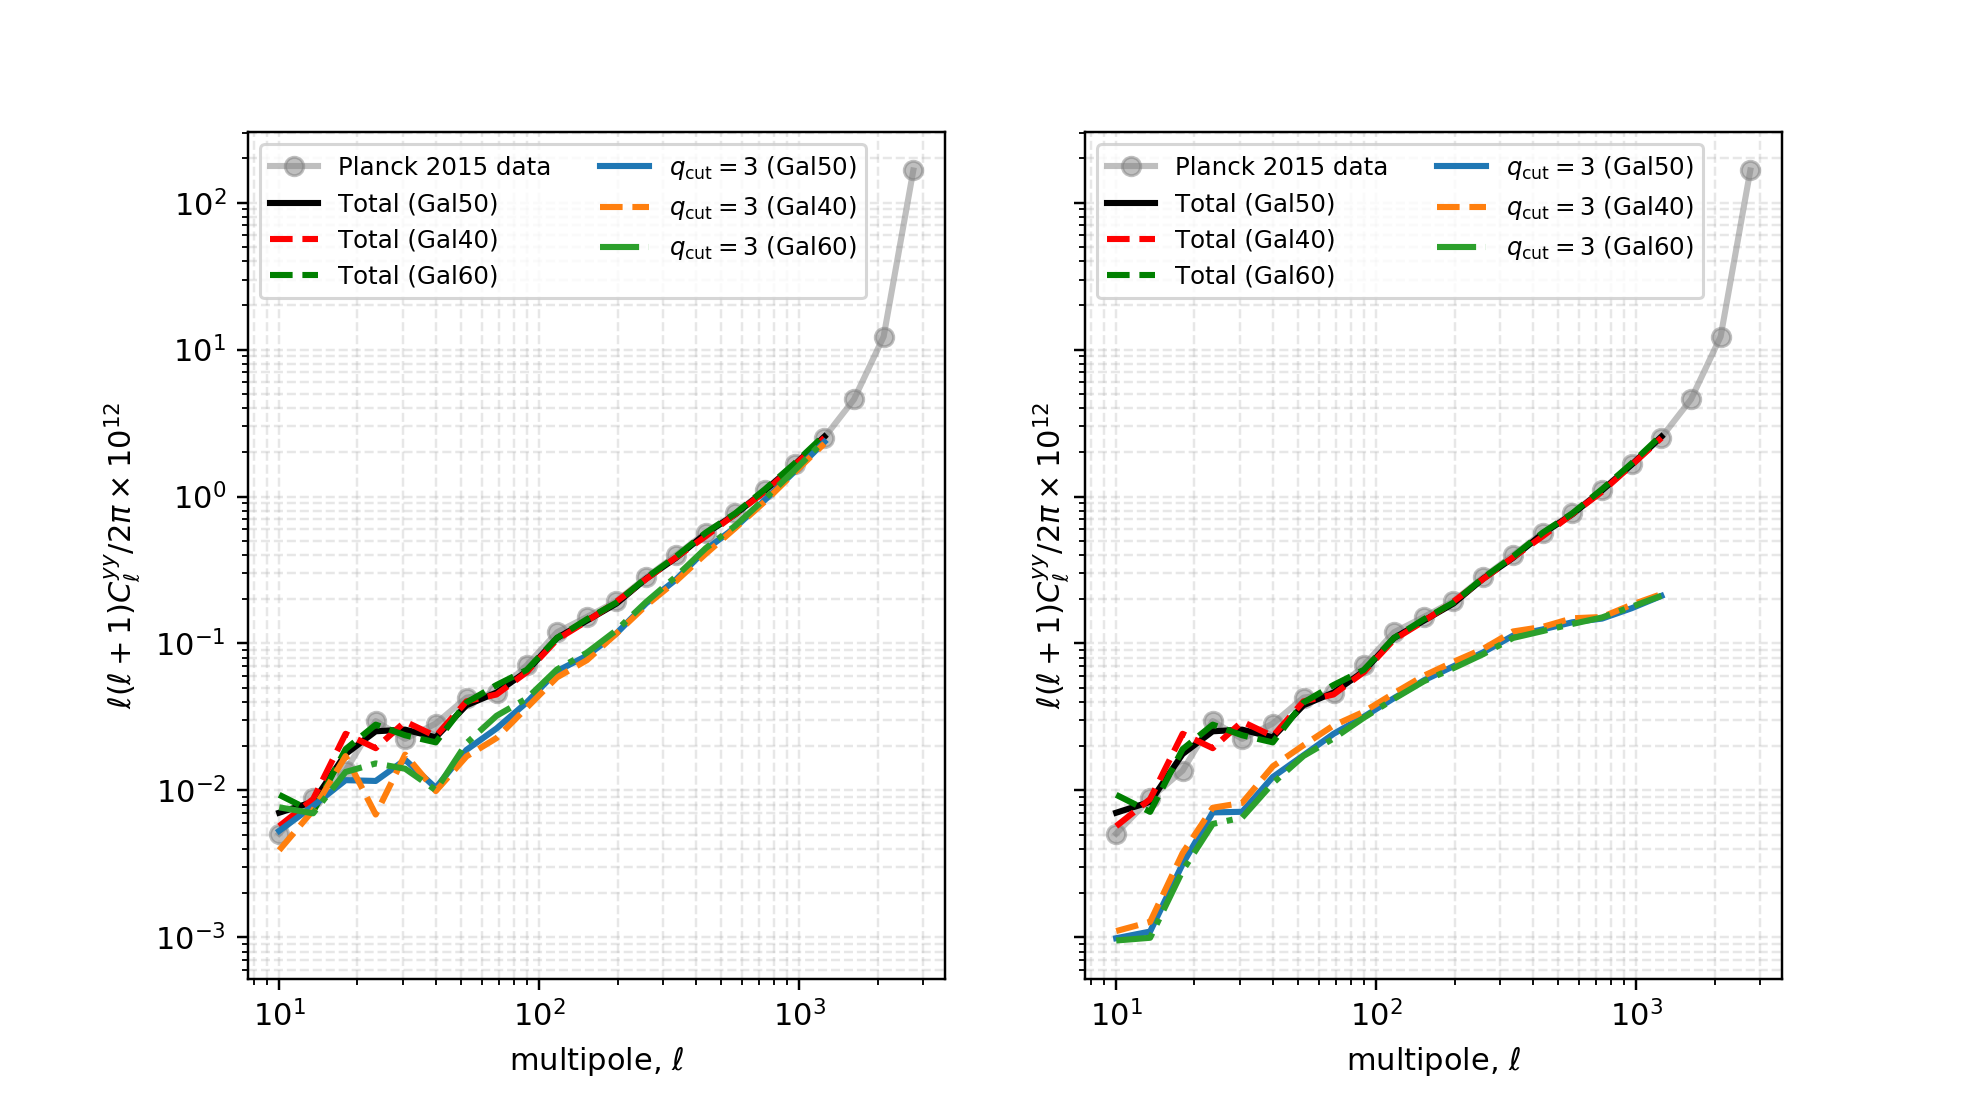

<IPython.core.display.Javascript object>


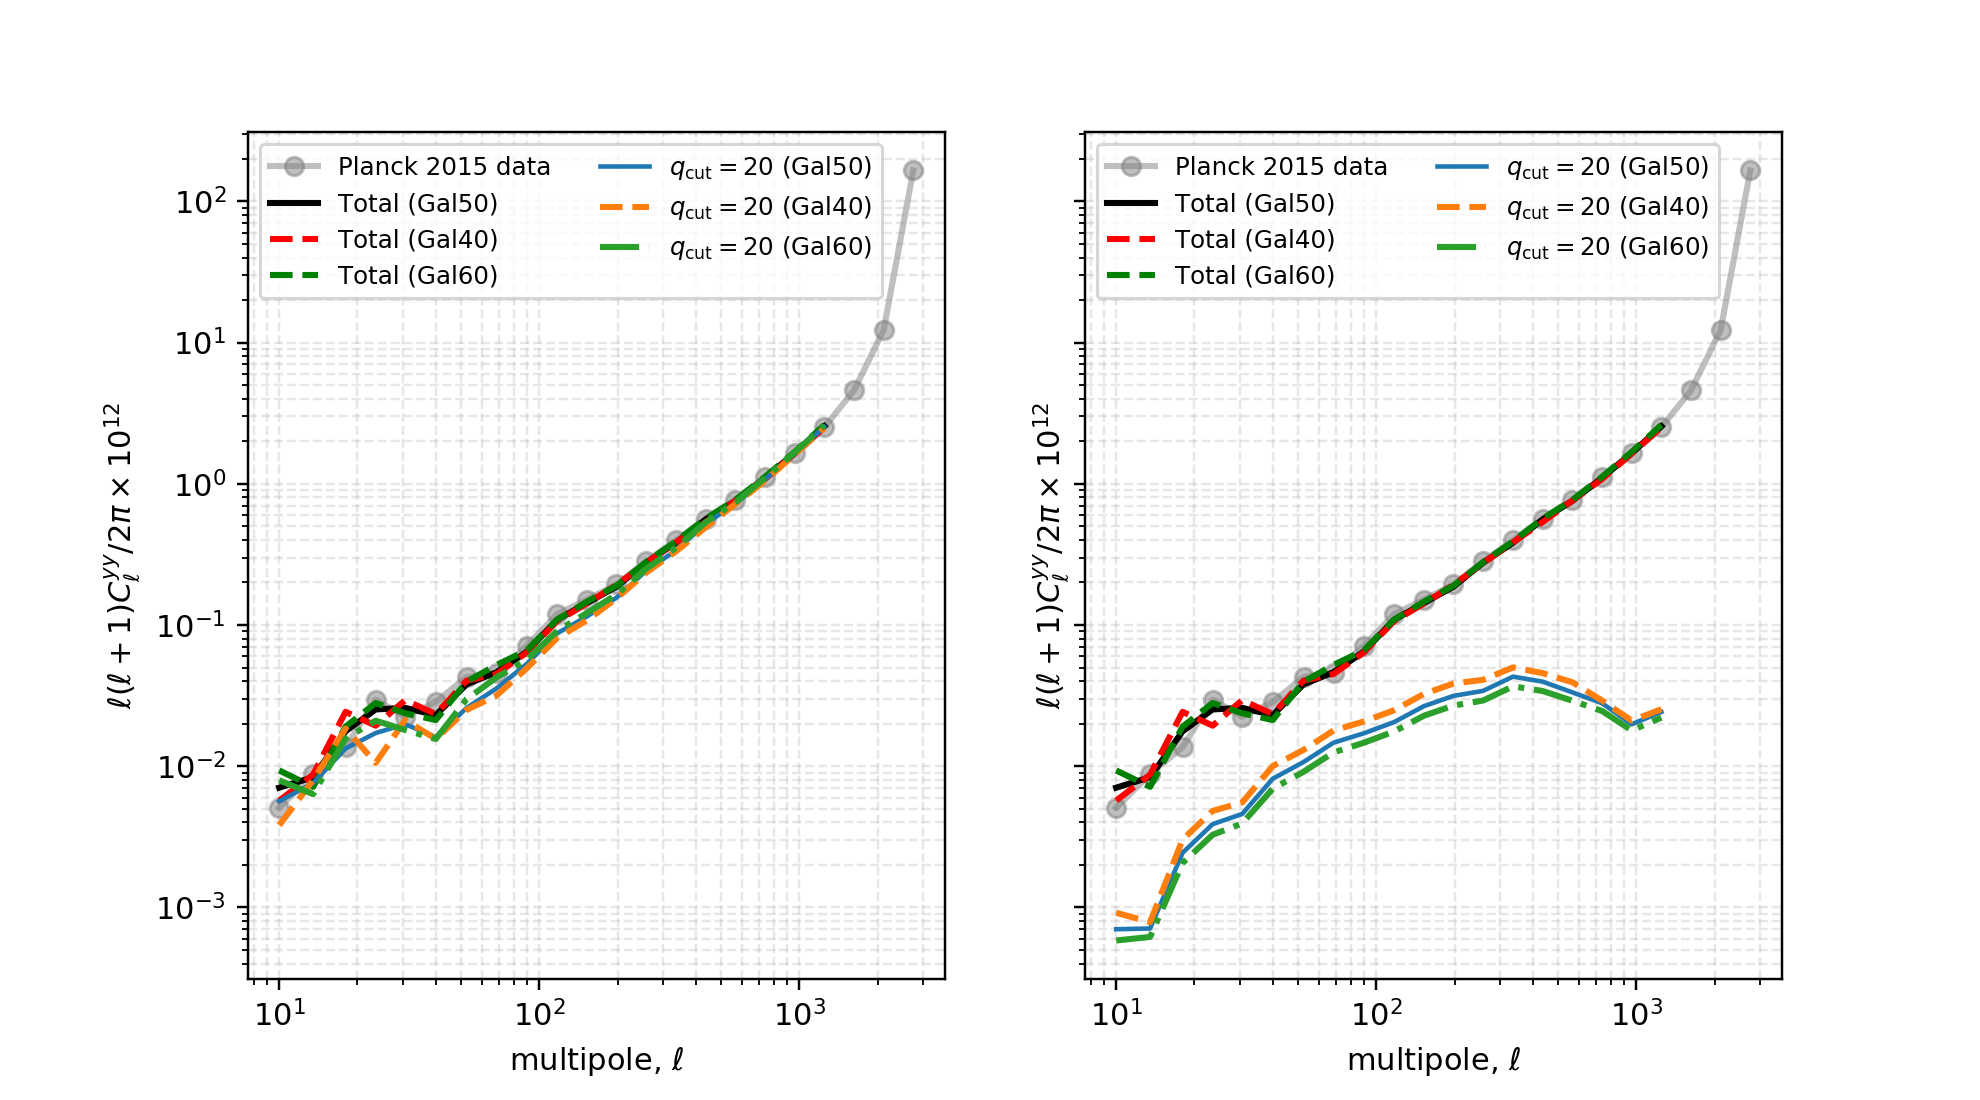

In [278]:
fig,ax=subplots(nrows=1,ncols=2,sharey=True,figsize=(9,5))
# figure()
ax[0].plot(planck_yy[:,0],planck_yy[:,1],"-o",color="gray",lw=2,label="Planck 2015 data",alpha=0.5)
ax[0].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total (Gal50)")
# ax[0].plot(tot_g30[:,2],tot_g30[:,3],"--",c="b",lw=2,label="Total (Gal30)")
ax[0].plot(tot_g40[:,2],tot_g40[:,3],"--",c="r",lw=2,label="Total (Gal40)")
ax[0].plot(tot_g60[:,2],tot_g60[:,3],"--",c="g",lw=2,label="Total (Gal60)")
ax[0].plot(urc3[:,2],urc3[:,3],lw=2,label=r"$q_{\rm cut}=3$ (Gal50)")
ax[0].plot(urc3_g40[:,2],urc3_g40[:,3],"--",lw=2,label=r"$q_{\rm cut}=3$ (Gal40)")
ax[0].plot(urc3_g60[:,2],urc3_g60[:,3],"-.",lw=2,label=r"$q_{\rm cut}=3$ (Gal60)")
ax[0].loglog()
ax[0].grid(which="both",alpha=0.3,linestyle="dashed")
ax[0].legend(loc=0,ncol=2,fontsize=8)
# ax[0].set_xlim(2,200)
ax[0].set_xlabel("multipole, $\ell$")
ax[0].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")

ax[1].plot(planck_yy[:,0],planck_yy[:,1],"-o",color="gray",lw=2,label="Planck 2015 data",alpha=0.5)
ax[1].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total (Gal50)")
ax[1].plot(tot_g40[:,2],tot_g40[:,3],"--",c="r",lw=2,label="Total (Gal40)")
ax[1].plot(tot_g60[:,2],tot_g60[:,3],"--",c="g",lw=2,label="Total (Gal60)")
ax[1].plot(rc3[:,2],rc3[:,3],lw=2,label=r"$q_{\rm cut}=3$ (Gal50)")
ax[1].plot(rc3_g40[:,2],rc3_g40[:,3],"--",lw=2,label=r"$q_{\rm cut}=3$ (Gal40)")
ax[1].plot(rc3_g60[:,2],rc3_g60[:,3],"-.",lw=2,label=r"$q_{\rm cut}=3$ (Gal60)")
ax[1].loglog()
ax[1].grid(which="both",alpha=0.3,linestyle="dashed")
ax[1].legend(loc=0,ncol=2,fontsize=8)
# ax[1].set_xlim(2,200)
ax[1].set_xlabel("multipole, $\ell$")
ax[1].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")
figname="../../results/yy_spec/qcut3_variable_mask.pdf"
savefig(figname, bbox_inches="tight",dpi=200)

fig,ax=subplots(nrows=1,ncols=2,sharey=True,figsize=(9,5))
# figure()
ax[0].plot(planck_yy[:,0],planck_yy[:,1],"-o",color="gray",lw=2,label="Planck 2015 data",alpha=0.5)
ax[0].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total (Gal50)")
ax[0].plot(tot_g40[:,2],tot_g40[:,3],"--",c="r",lw=2,label="Total (Gal40)")
ax[0].plot(tot_g60[:,2],tot_g60[:,3],"--",c="g",lw=2,label="Total (Gal60)")
ax[0].plot(urc20[:,2],urc20[:,3],label=r"$q_{\rm cut}=20$ (Gal50)")
ax[0].plot(urc20_g40[:,2],urc20_g40[:,3],"--",lw=2,label=r"$q_{\rm cut}=20$ (Gal40)")
ax[0].plot(urc20_g60[:,2],urc20_g60[:,3],"-.",lw=2,label=r"$q_{\rm cut}=20$ (Gal60)")
ax[0].loglog()
ax[0].grid(which="both",alpha=0.3,linestyle="dashed")
ax[0].legend(loc=0,ncol=2,fontsize=8)
ax[0].set_xlabel("multipole, $\ell$")
ax[0].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")

ax[1].plot(planck_yy[:,0],planck_yy[:,1],"-o",color="gray",lw=2,label="Planck 2015 data",alpha=0.5)
ax[1].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total (Gal50)")
ax[1].plot(tot_g40[:,2],tot_g40[:,3],"--",c="r",lw=2,label="Total (Gal40)")
ax[1].plot(tot_g60[:,2],tot_g60[:,3],"--",c="g",lw=2,label="Total (Gal60)")
ax[1].plot(rc20[:,2],rc20[:,3],label=r"$q_{\rm cut}=20$ (Gal50)")
ax[1].plot(rc20_g40[:,2],rc20_g40[:,3],'--',lw=2,label=r"$q_{\rm cut}=20$ (Gal40)")
ax[1].plot(rc20_g60[:,2],rc20_g60[:,3],'-.',lw=2,label=r"$q_{\rm cut}=20$ (Gal60)")
ax[1].loglog()
ax[1].grid(which="both",alpha=0.3,linestyle="dashed")
ax[1].legend(loc=0,ncol=2,fontsize=8)
# ax[1].set_xlim(2,200)
ax[1].set_xlabel("multipole, $\ell$")
ax[1].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")
figname="../../results/yy_spec/qcut20_variable_mask.pdf"
savefig(figname, bbox_inches="tight",dpi=200)

# Generate point source mask
- The point source mask is generated at the full resolution of NSIDE=2048. Only after multiplying with the galactic mask is the final mask degraded to a lower resolution of NSIDE=512 for the spectral analysis.

In [48]:
# if lf_ps_mask:
#     gset.mmfset.ps_mask_weights[30.]=1.
#     gset.mmfset.ps_mask_weights[44.]=1.
#     gset.mmfset.ps_mask_weights[70.]=1.
# else:
#     gset.mmfset.ps_mask_weights[30.]=0.
#     gset.mmfset.ps_mask_weights[44.]=0.
#     gset.mmfset.ps_mask_weights[70.]=0.
# print gset.mmfset.ps_mask_weights
# psmask=ppd.gen_ps_mask(snrthr=5.,ps_cutoff=5.)

{353.0: 1.0, 100.0: 1.0, 70.0: 0.0, 545.0: 1.0, 44.0: 0.0, 143.0: 1.0, 857.0: 1.0, 217.0: 1.0, 30.0: 0.0}


# Read in the MILCA and NILC y-maps and downgrade to speed up spectral analysis

In [198]:
fname=datapath + "/maps/COM_CompMap_Compton-SZMap-masks_2048_R2.01.fits"
gmask60=h.read_map(fname,0,verbose=False)
gmask50=h.read_map(fname,1,verbose=False)
gmask40=h.read_map(fname,2,verbose=False)
gmask30=h.read_map(fname,3,verbose=False)
psmask=h.read_map(fname,4,verbose=False)

<IPython.core.display.Javascript object>


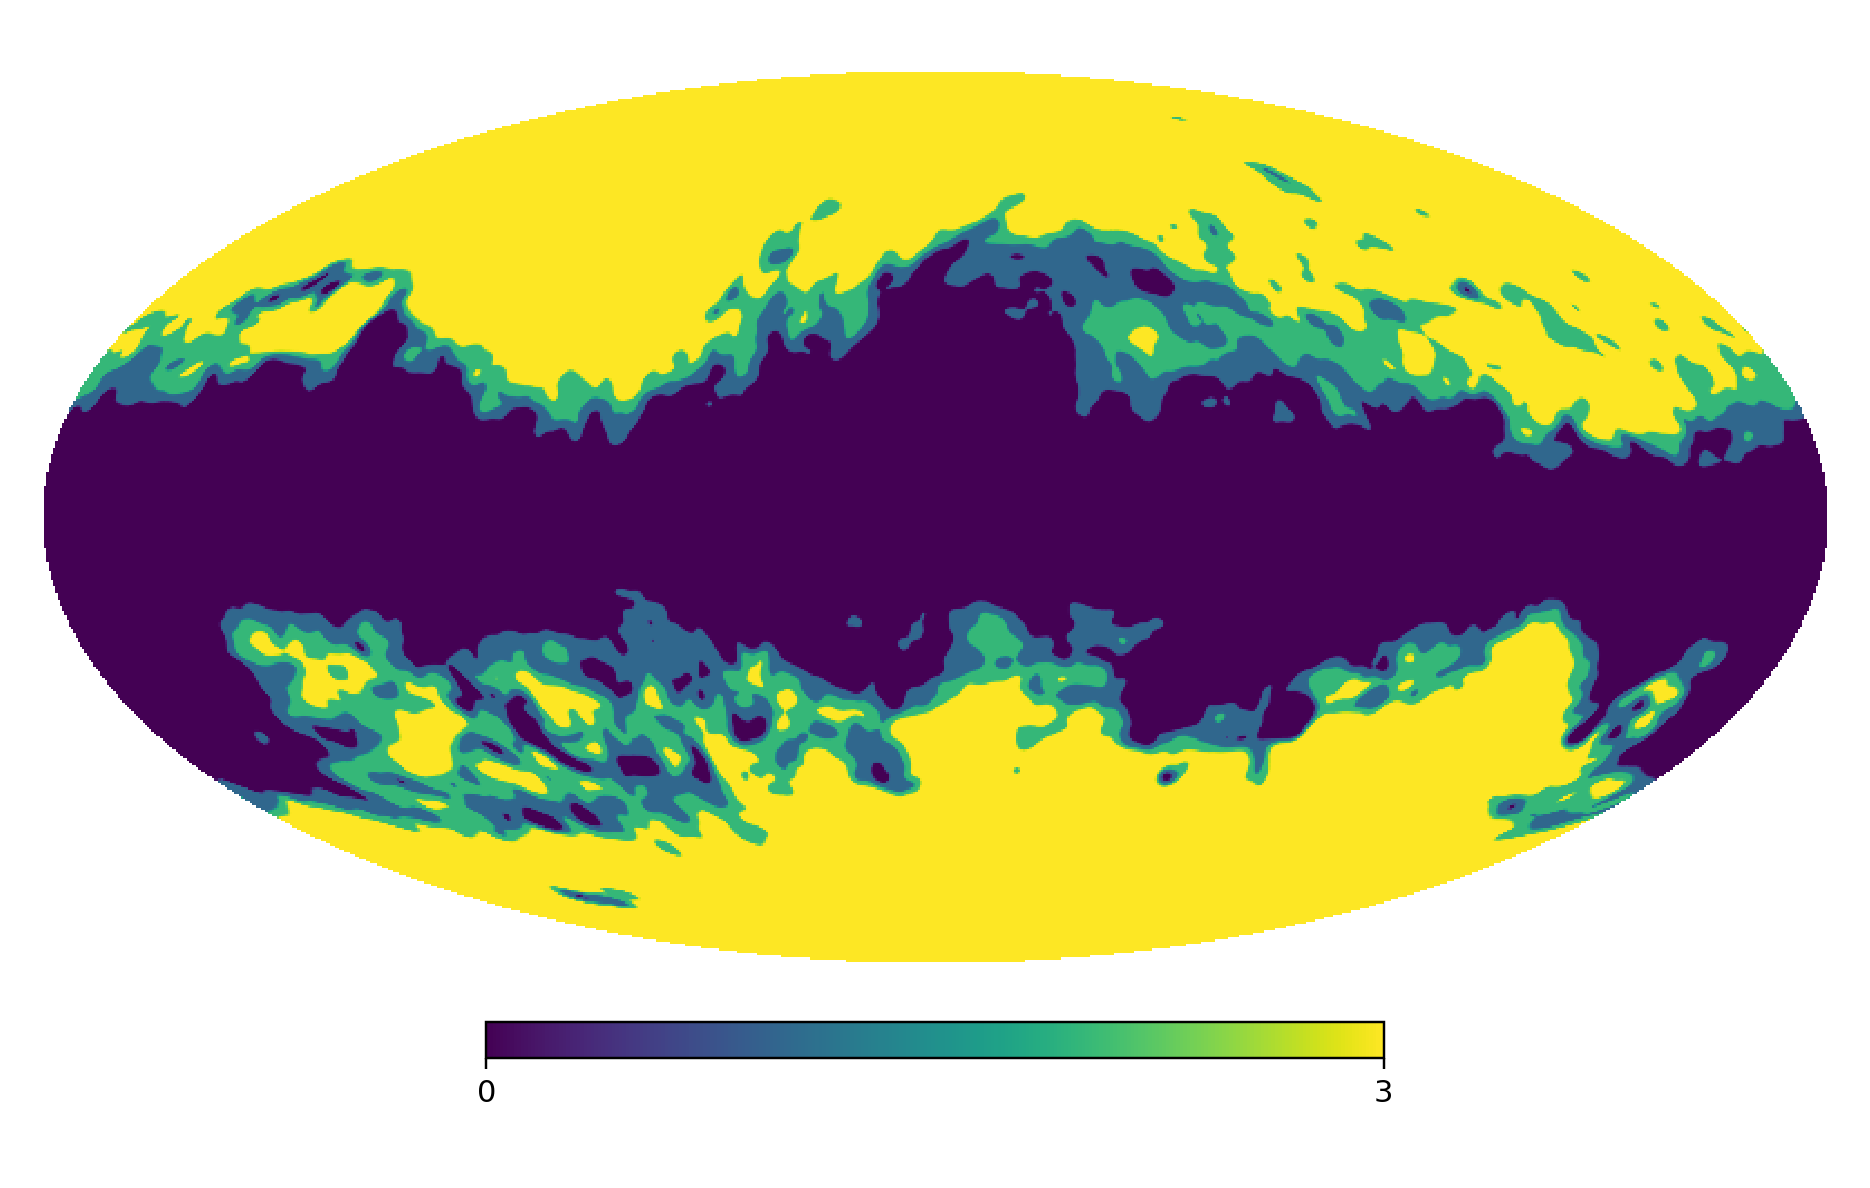

In [276]:
h.mollview(gmask60+gmask50+gmask40,title="")
figname="../../results/yy_spec/" + "Gal60_gal50_gal40.pdf"
savefig(figname,bbox_inches="tight")

In [288]:
fname=datapath + "/maps/COM_CompMap_Compton-SZMap-masks_2048_R2.01.fits"
gmask=h.read_map(fname,1,verbose=False)
mask=gmask*psmask

fname=datapath + "/maps/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00.fits"
nilc=h.read_map(fname,0,verbose=False)
nilc_f=h.read_map(fname,1,verbose=False)
nilc_l=h.read_map(fname,2,verbose=False)

fname=datapath + "/maps/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits"
milca=h.read_map(fname,0,verbose=False)
milca_f=h.read_map(fname,1,verbose=False)
milca_l=h.read_map(fname,2,verbose=False)


if do_dgrade:
    mask=h.ud_grade(mask,nsideout) ; mask[mask>=0.2]=1. ; mask[mask<0.2]=0.
    gmask=h.ud_grade(gmask,nsideout) ; gmask[gmask>=0.2]=1. ; gmask[gmask<0.2]=0.
    nilc=h.ud_grade(nilc,nsideout)
    nilc_f=h.ud_grade(nilc_f,nsideout)
    nilc_l=h.ud_grade(nilc_l,nsideout)
    milca=h.ud_grade(milca,nsideout)
    milca_f=h.ud_grade(milca_f,nsideout)
    milca_l=h.ud_grade(milca_l,nsideout)

nside=h.get_nside(mask)
print nside

2048


In [50]:
fname=datapath + "/maps/COM_CompMap_Compton-SZMap-masks_2048_R2.01.fits"
ofile=fits.open(fname)
ofile.close()
psmask1=h.read_map(fname,field=4)

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


<IPython.core.display.Javascript object>


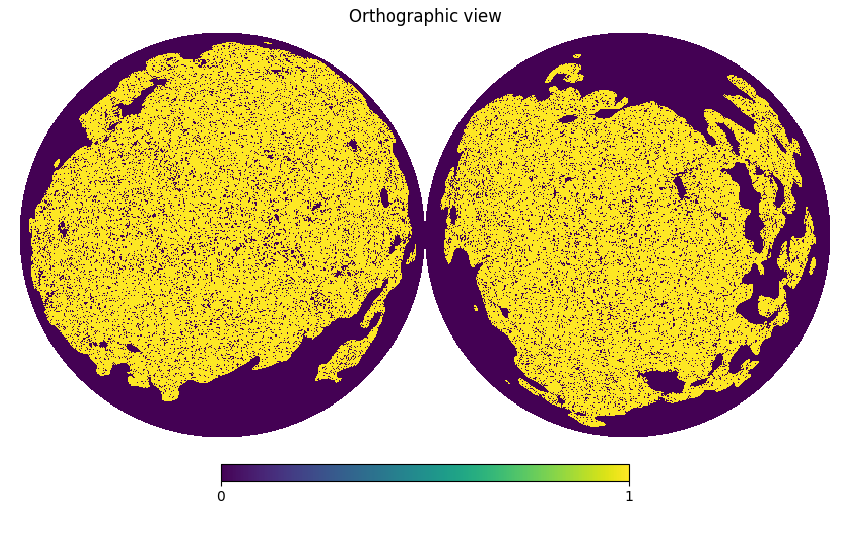

<IPython.core.display.Javascript object>


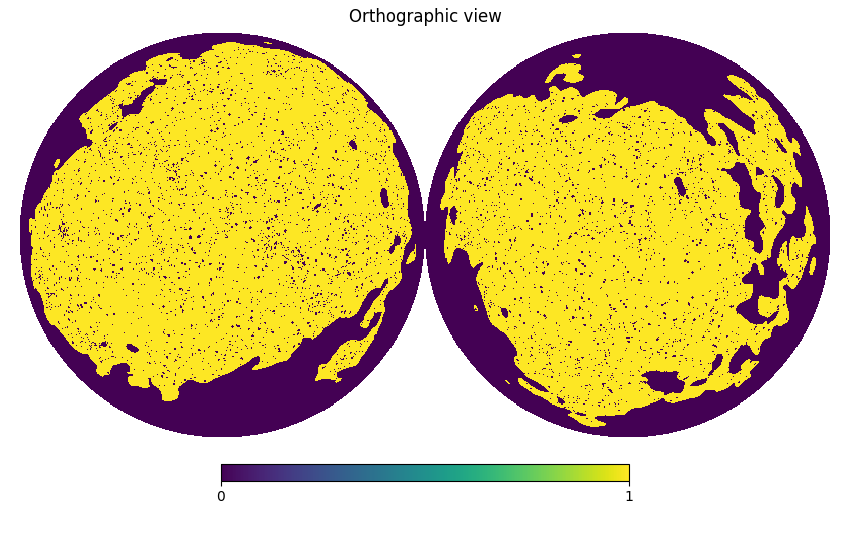

In [51]:
h.orthview(psmask1*gmask,rot=(0,90))
h.orthview(psmask*gmask,rot=(0,90))

# Generate the cluster mask. 
- The VIRGO and COMA mask are generated separately as the prescription used to evaluate the
size of the mask for other clusters does not fully mask these clusters, especially VIRGO.


In [10]:
virgo_mask=np.ones_like(mask)
virgo_glon=279.6763 ; virgo_glat=74.4596
pixcs=h.ang2pix(nside,virgo_glon,virgo_glat,lonlat=True) ; vec=h.pix2vec(nside,pixcs)
radius=3.*np.pi/180.
disc_pix=h.query_disc(nside,vec,radius=radius,fact=4,inclusive=True)
virgo_mask[disc_pix]=0.0

coma_mask=np.ones_like(mask)
coma_glon=058.0791 ; coma_glat=87.9577
pixcs=h.ang2pix(nside,coma_glon,coma_glat,lonlat=True) ; vec=h.pix2vec(nside,pixcs)
radius=3.*np.pi/180.
disc_pix=h.query_disc(nside,vec,radius=radius,fact=4,inclusive=True)
coma_mask[disc_pix]=0.0

#h.orthview(virgo_mask,rot=(0,90))

clmask=np.ones_like(mask)
pixcs=h.ang2pix(nside,mmf3["GLON"],mmf3["GLAT"],lonlat=True)
radius=5.*(mmf3["theta500"]/60.)*np.pi/180.
for i,pix in enumerate(pixcs):
    vec=h.pix2vec(nside,pix)
    disc_pix=h.query_disc(nside,vec,radius=radius[i],fact=4,inclusive=True)
    clmask[disc_pix]=0.0
    
clmask=clmask*virgo_mask*coma_mask

fsky_tot=sum(mask)/size(mask)
fsky_diff=sum(mask*clmask)/size(mask)
fsky_res=sum(mask*(1.-clmask))/size(mask)
print fsky_tot,fsky_diff,fsky_res

0.432395001252 0.419417699178 0.0129773020744


<IPython.core.display.Javascript object>


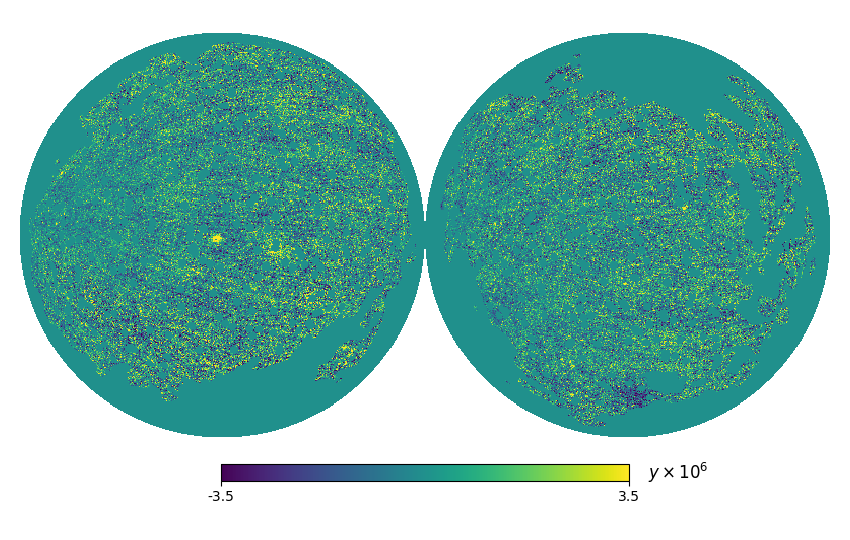

<IPython.core.display.Javascript object>


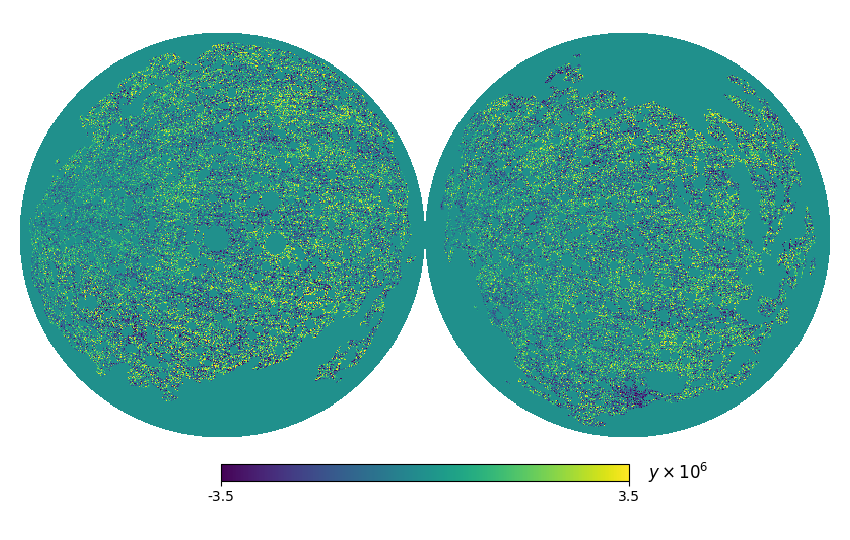

<IPython.core.display.Javascript object>


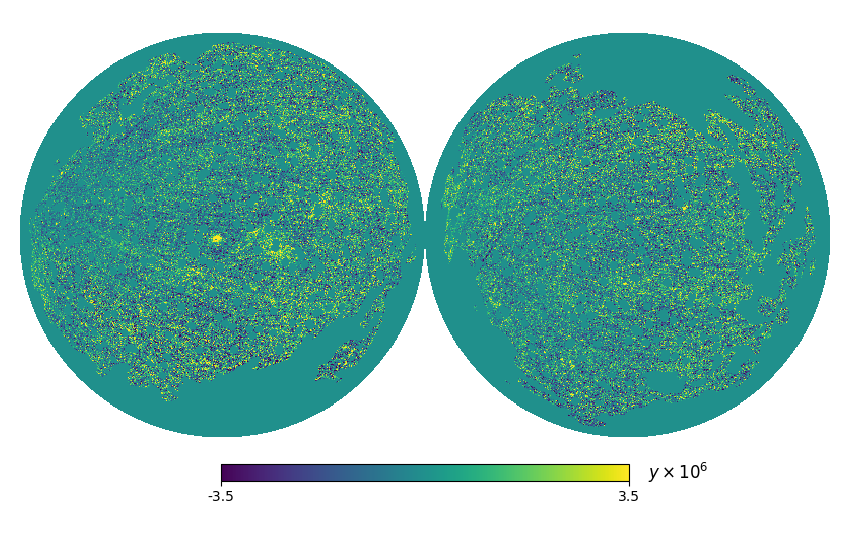

<IPython.core.display.Javascript object>


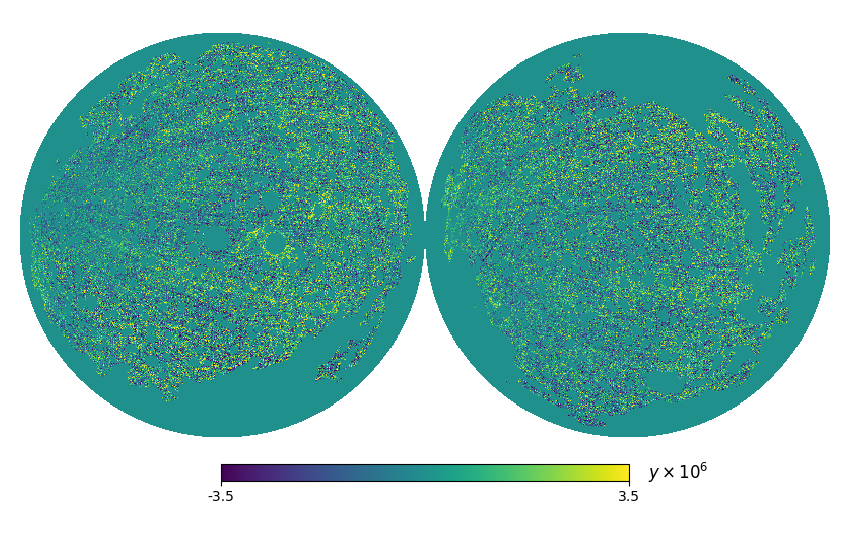

In [11]:
h.orthview(nilc*mask*1e6,min=-3.5,max=3.5,rot=(0,90),title="")
text(1.1,-1.2,r"$y \times 10^6$",fontsize=12)
figname=figpath + "nilc_before_clmask.pdf"
savefig(figname,bbox_inches="tight")

h.orthview(nilc*clmask*mask*1e6,min=-3.5,max=3.5,rot=(0,90),title="")
text(1.1,-1.2,r"$y \times 10^6$",fontsize=12)
figname=figpath + "nilc_after_clmask.pdf"
savefig(figname,bbox_inches="tight")

h.orthview(milca*mask*1e6,min=-3.5,max=3.5,rot=(0,90),title="")
text(1.1,-1.2,r"$y \times 10^6$",fontsize=12)
figname=figpath + "milca_before_clmask.pdf"
savefig(figname,bbox_inches="tight")

h.orthview(milca*clmask*mask*1e6,min=-3.5,max=3.5,rot=(0,90),title="")
text(1.1,-1.2,r"$y \times 10^6$",fontsize=12)
figname=figpath + "milca_after_clmask.pdf"
savefig(figname,bbox_inches="tight")

## Generate apodized masks

In [14]:
gal_ps_mask=mask
gal_ps_cl_mask=mask*clmask
gal_ps_ccl_mask=mask*(1.-clmask)

if apowidth>0.:
    nside=h.get_nside(mask) ; npixtot=h.nside2npix(nside)
    gal_ps_mask=gen_apo_mask.gen_apodized_mask(gal_ps_mask,nside,1,0.,0.,apowidth,npixtot)
    gal_ps_cl_mask=gen_apo_mask.gen_apodized_mask(gal_ps_cl_mask,nside,1,0.,0.,apowidth,npixtot)
    gal_ps_ccl_mask=gen_apo_mask.gen_apodized_mask(gal_ps_ccl_mask,nside,1,0.,0.,apowidth,npixtot)

<IPython.core.display.Javascript object>


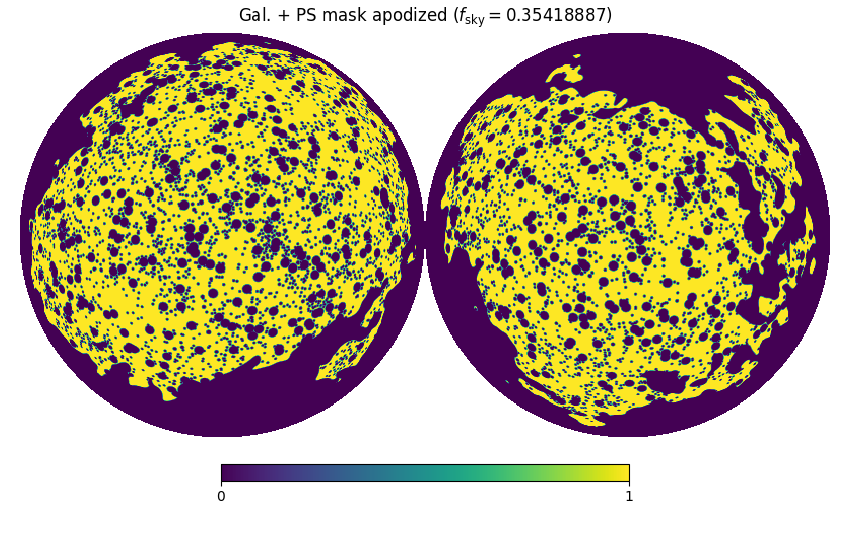

<IPython.core.display.Javascript object>


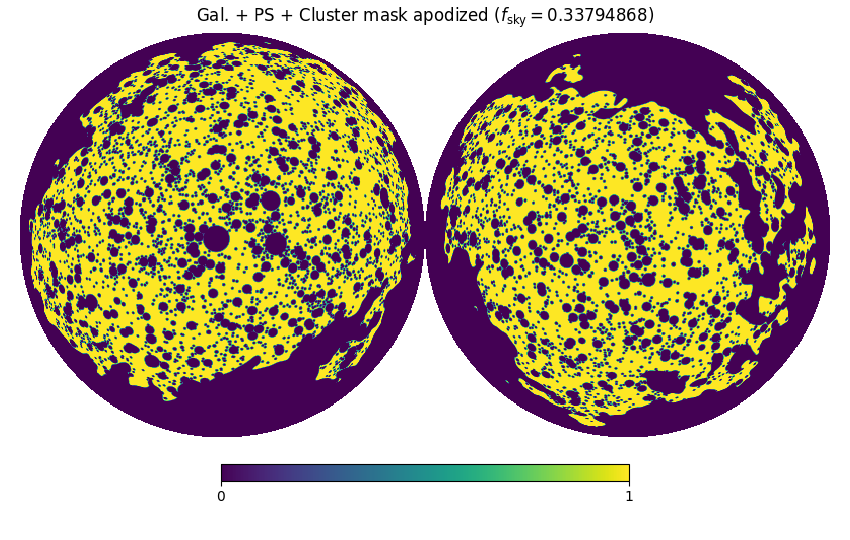

<IPython.core.display.Javascript object>


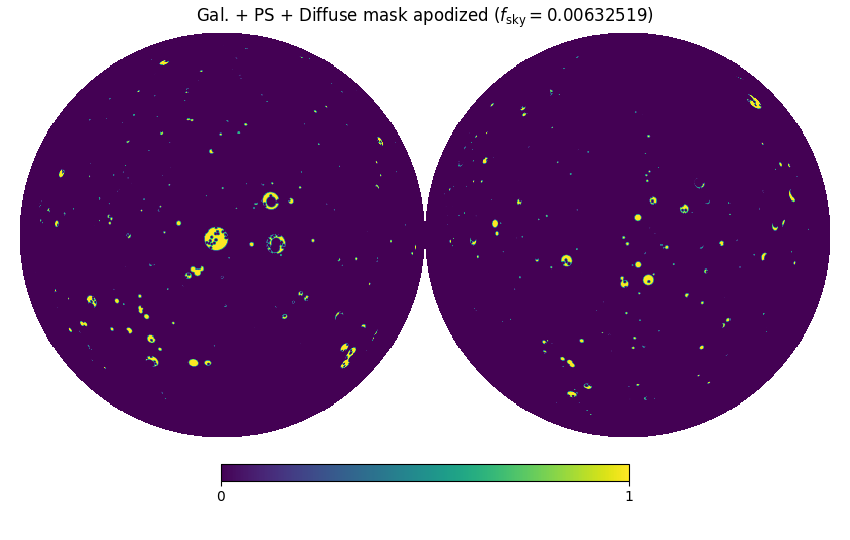

In [17]:
fsky=sum(gal_ps_mask)/size(gal_ps_mask)
h.orthview(gal_ps_mask,rot=(0,90),title=r"Gal. + PS mask apodized $(f_{\rm sky}=" + str(round(fsky,8)) + ")$")
figname=figpath + "gal_ps_mask_apo.pdf"
savefig(figname,bbox_inches="tight")

fsky=sum(gal_ps_cl_mask)/size(gal_ps_mask)
h.orthview(gal_ps_cl_mask,rot=(0,90),title=r"Gal. + PS + Cluster mask apodized $(f_{\rm sky}=" + str(round(fsky,8)) + ")$")
figname=figpath + "gal_ps_cl_mask_apo.pdf"
savefig(figname,bbox_inches="tight")

fsky=sum(gal_ps_ccl_mask)/size(gal_ps_mask)
h.orthview(gal_ps_ccl_mask,rot=(0,90),title=r"Gal. + PS + Diffuse mask apodized $(f_{\rm sky}=" + str(round(fsky,8)) + ")$")
figname=figpath + "gal_ps_ccl_mask_apo.pdf"
savefig(figname,bbox_inches="tight")

# Histogram 

<IPython.core.display.Javascript object>


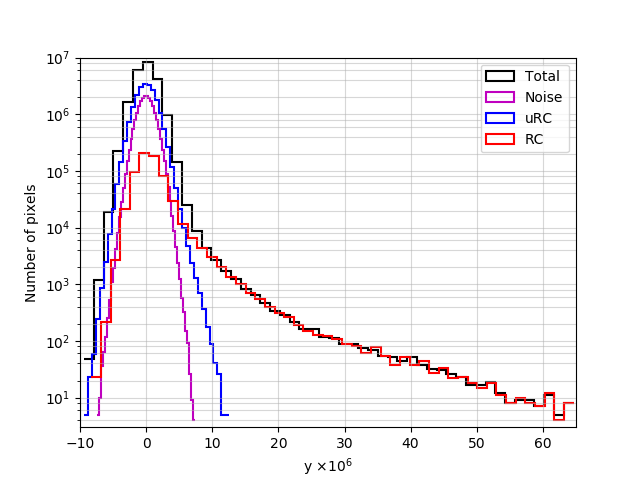

<IPython.core.display.Javascript object>


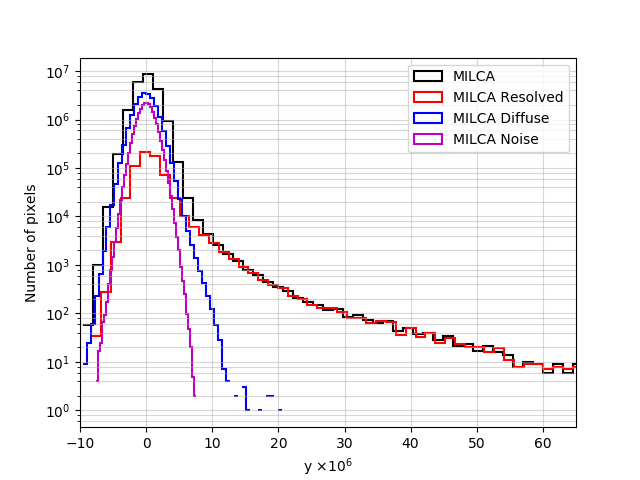

In [18]:
figure()
a,b,c=hist(nilc[mask!=0]*1e6,histtype="step",bins=50,normed=False,label="Total",lw=1.5,color="k")
a,b,c=hist(((nilc_f-nilc_l)/2.)[mask*clmask!=0]*1e6,histtype="step",bins=50,normed=False,label="Noise",lw=1.5,color="m")
a,b,c=hist(nilc[mask*clmask!=0]*1e6,histtype="step",bins=50,normed=False,label="uRC",lw=1.5,color="b")
a,b,c=hist(nilc[mask*(1-clmask)!=0]*1e6,histtype="step",bins=50,normed=False,label="RC",lw=1.5,color="r")
semilogy()
legend(loc=0)
ylim(3,1e7)
xlim(-10,65)
grid(alpha=0.5,which="both")
figname=figpath + "y_nilc_histogram.pdf"
xlabel(r"y $\times 10^6$")
ylabel("Number of pixels")
savefig(figname,bbox_inches="tight")

figure()
a,b,c=hist(milca[mask!=0]*1e6,histtype="step",bins=50,normed=False,label="MILCA",lw=1.5,color="k")
a,b,c=hist(milca[mask*(1-clmask)!=0]*1e6,histtype="step",bins=50,normed=False,label="MILCA Resolved",lw=1.5,color="r")
a,b,c=hist(milca[mask*clmask!=0]*1e6,histtype="step",bins=50,normed=False,label="MILCA Diffuse",lw=1.5,color="b")
a,b,c=hist(((milca_f-milca_l)/2.)[mask*clmask!=0]*1e6,histtype="step",bins=50,normed=False,label="MILCA Noise",lw=1.5,color="m")
semilogy()
legend(loc=0)
#ylim(1e-6,0.5)
xlim(-10,65)
grid(alpha=0.5,which="both")
figname=figpath + "y_milca_histogram.pdf"
xlabel(r"y $\times 10^6$")
ylabel("Number of pixels")
savefig(figname,bbox_inches="tight")

# Generate map figures

<IPython.core.display.Javascript object>


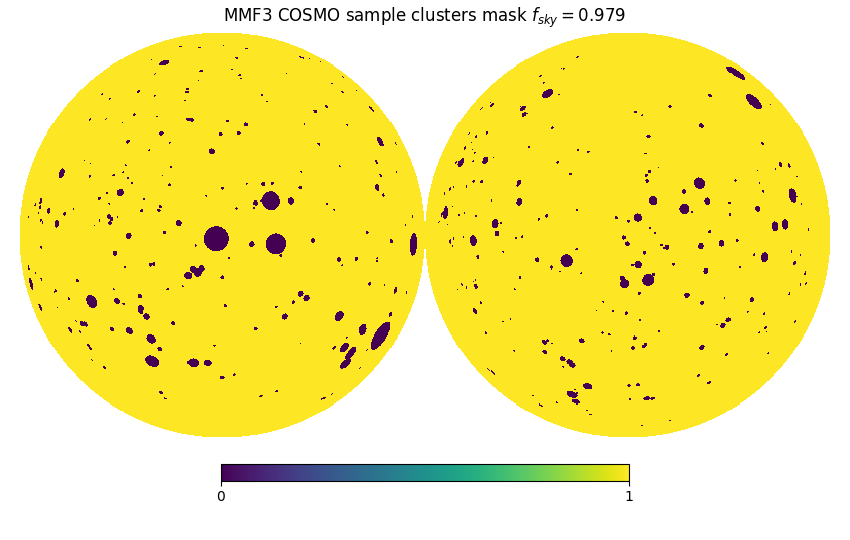

<IPython.core.display.Javascript object>


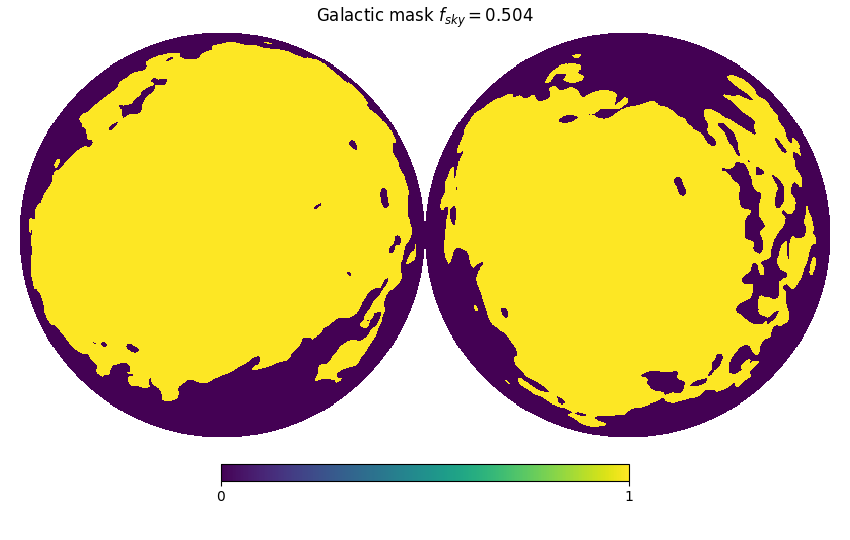

<IPython.core.display.Javascript object>


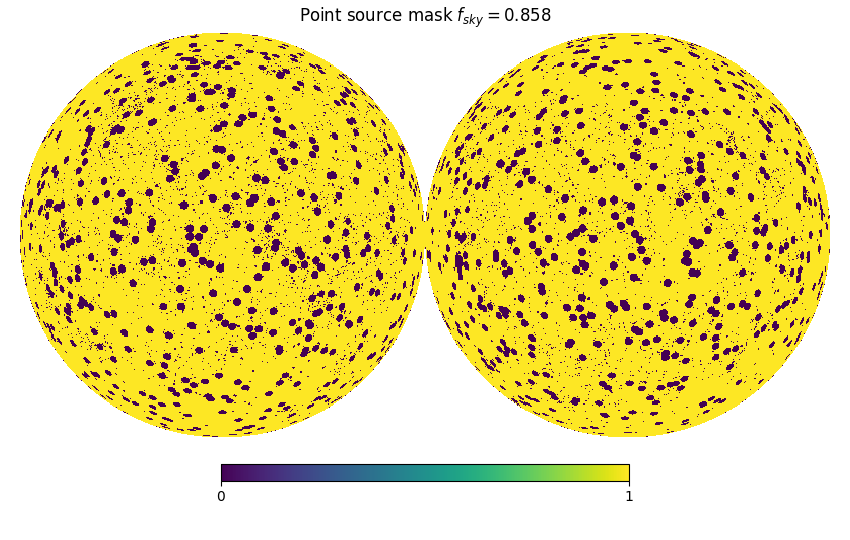

In [19]:
fsky=sum(clmask)/size(gmask)
h.orthview(clmask,rot=(0,90),title="MMF3 COSMO sample clusters mask $f_{sky}=" + str(round(fsky,3)) + "$")
figname=figpath + "cluster_mask.pdf"
savefig(figname,bbox_inches="tight")

fsky=sum(gmask)/size(gmask)
h.orthview(gmask,rot=(0,90),title="Galactic mask $f_{sky}=" + str(round(fsky,3)) + "$")
figname=figpath + "gal_mask.pdf"
savefig(figname,bbox_inches="tight")

fsky=sum(psmask)/size(psmask)
h.orthview(psmask,rot=(0,90),title="Point source mask $f_{sky}=" + str(round(fsky,3)) + "$")
figname=figpath + "ps_mask.pdf"
savefig(figname,bbox_inches="tight")

# Power spectrum analysis

In [32]:
# Total
tmask=gal_ps_mask ; fsky_tot_apo=sum(tmask)/size(tmask)
alm_milca=h.map2alm(milca_l*tmask,lmax=lmax) ; alm_nilc=h.map2alm(nilc_f*tmask,lmax=lmax)
nilc_milca_tot=h.alm2cl(alm_nilc,alm_milca)
nilc_hm1_tot=h.alm2cl(alm_nilc,alm_nilc)
milca_hm2_tot=h.alm2cl(alm_milca,alm_milca)
#nilc_tot=h.alm2cl(h.map2alm(nilc_f*tmask,lmax=lmax),h.map2alm(nilc_l*tmask,lmax=lmax))
#milca_tot=h.alm2cl(h.map2alm(milca_f*tmask,lmax=lmax),h.map2alm(milca_l*tmask,lmax=lmax))
print "Total done"

# Diffuse
tmask=gal_ps_cl_mask ; fsky_diff_apo=sum(tmask)/size(tmask)
alm_milca=h.map2alm(milca_l*tmask,lmax=lmax) ; alm_nilc=h.map2alm(nilc_f*tmask,lmax=lmax)
nilc_milca_diff=h.alm2cl(alm_nilc,alm_milca)
nilc_hm1_diff=h.alm2cl(alm_nilc,alm_nilc)
milca_hm2_diff=h.alm2cl(alm_milca,alm_milca)
#nilc_diff=h.alm2cl(h.map2alm(nilc_f*tmask,lmax=lmax),h.map2alm(nilc_l*tmask,lmax=lmax))
#milca_diff=h.alm2cl(h.map2alm(milca_f*tmask,lmax=lmax),h.map2alm(milca_l*tmask,lmax=lmax))
print "Diffuse done"

# Resolved
tmask=gal_ps_ccl_mask ; fsky_res_apo=sum(tmask)/size(tmask)
alm_milca=h.map2alm(milca_l*tmask,lmax=lmax) ; alm_nilc=h.map2alm(nilc_f*tmask,lmax=lmax)
nilc_milca_res=h.alm2cl(alm_nilc,alm_milca)
nilc_hm1_res=h.alm2cl(alm_nilc,alm_nilc)
milca_hm2_res=h.alm2cl(alm_milca,alm_milca)
print "Resolved done"
#nilc_res=h.alm2cl(h.map2alm(nilc_f*tmask,lmax=lmax),h.map2alm(nilc_l*tmask,lmax=lmax))
#milca_res=h.alm2cl(h.map2alm(milca_f*tmask,lmax=lmax),h.map2alm(milca_l*tmask,lmax=lmax))

Total done
Diffuse done
Resolved done


In [292]:
0.345/0.354

0.9745762711864406

In [264]:
planckyy=np.loadtxt(datapath + "/maps/planck2015_yy_ps.txt")
bmin=planckyy[:,3]
bmax=planckyy[:,4]

# Data from Boris's papers
planck_yy=np.loadtxt(datapath + "/maps/bolliet2018.txt")

In [34]:
beam=h.gauss_beam(fwhm=(10./60.)*pi/180.,lmax=lmax)*h.pixwin(nside)[:lmax+1]

mtot=bm.binned_master(gal_ps_mask,2,lmax,masklmax,beam=beam,bmin=bmin,bmax=bmax)
print "Total done"

mdiff=bm.binned_master(gal_ps_cl_mask,2,lmax,masklmax,beam=beam,bmin=bmin,bmax=bmax)
print "Diffuse done"

mres=bm.binned_master(gal_ps_ccl_mask,2,lmax,masklmax,beam=beam,bmin=bmin,bmax=bmax)
print "Resolved done"

Total done
Diffuse done
Resolved done


# CIB

In [86]:
fname=datapath + "/maps/COM_CompMap_CIB-GNILC-F353_2048_R2.00.fits"
cib353=h.read_map(fname,verbose=False)

alm_cib_tot=h.map2alm(cib353*gal_ps_mask,lmax=lmax)
alm_cib_res=h.map2alm(cib353*gal_ps_ccl_mask,lmax=lmax)
alm_cib_diff=h.map2alm(cib353*gal_ps_cl_mask,lmax=lmax)

In [88]:
cl_cib_tot=h.alm2cl(alm_cib_tot)
cl_cib_diff=h.alm2cl(alm_cib_diff)
cl_cib_res=h.alm2cl(alm_cib_res)

In [89]:
plnck_frg=np.loadtxt(datapath + "/maps/SZ_and_fg_models.txt")

In [92]:
figpath

'../../results/yy_spec//snr6_lmax1500_mlmax4096_apow30_lfpsT/figs/'

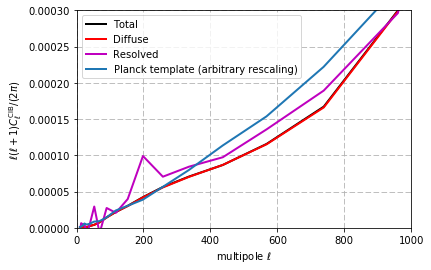

In [90]:
lbin,m_cib_tot=mtot.return_bmcs(cl_cib_tot)
lbin,m_cib_diff=mdiff.return_bmcs(cl_cib_diff)
lbin,m_cib_res=mres.return_bmcs(cl_cib_res)

figure()
plot(lbin,m_cib_tot,"k-",lw=2,label="Total")
plot(lbin,m_cib_diff,"r-",lw=2,label="Diffuse")
plot(lbin,m_cib_res,"m-",lw=2,label="Resolved")
plot(plnck_frg[:,0],plnck_frg[:,1]*2e-4,lw=2,label="Planck template (arbitrary rescaling)")
ylabel(r"$\ell(\ell+1)C_{\ell}^{\rm CIB} / (2 \pi)$")
xlabel(r"multipole $\ell$")
grid(which="both",linestyle="dashed")
xlim(0,1000)
ylim(0,0.0003)
legend(loc=0)
figname=figpath + "cib_spectrum_comparison.pdf"
savefig(figname,bbox_inches="tight")

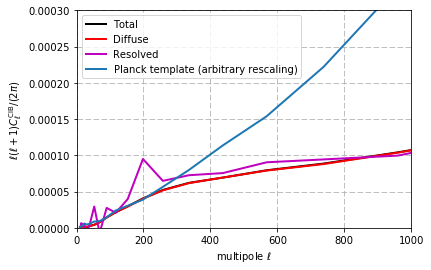

In [91]:
bl10=h.gauss_beam(fwhm=(10./60.)*pi/180.,lmax=lmax)
bl5=h.gauss_beam(fwhm=(5./60.)*pi/180.,lmax=lmax)
bl=bl10/bl5
alm_cib_tot=h.almxfl(alm_cib_tot,fl=bl)
alm_cib_diff=h.almxfl(alm_cib_diff,fl=bl)
alm_cib_res=h.almxfl(alm_cib_res,fl=bl)

cl_cib_tot=h.alm2cl(alm_cib_tot)
cl_cib_diff=h.alm2cl(alm_cib_diff)
cl_cib_res=h.alm2cl(alm_cib_res)

lbin,m_cib_tot=mtot.return_bmcs(cl_cib_tot)
lbin,m_cib_diff=mdiff.return_bmcs(cl_cib_diff)
lbin,m_cib_res=mres.return_bmcs(cl_cib_res)

figure()
plot(lbin,m_cib_tot,"k-",lw=2,label="Total")
plot(lbin,m_cib_diff,"r-",lw=2,label="Diffuse")
plot(lbin,m_cib_res,"m-",lw=2,label="Resolved")
plot(plnck_frg[:,0],plnck_frg[:,1]*2e-4,lw=2,label="Planck template (arbitrary rescaling)")
ylabel(r"$\ell(\ell+1)C_{\ell}^{\rm CIB} / (2 \pi)$")
xlabel(r"multipole $\ell$")
grid(which="both",linestyle="dashed")
xlim(0,1000)
ylim(0,0.0003)
legend(loc=0)
figname=figpath + "cib_spectrum_comparison_with_deconvolution.pdf"
savefig(figname,bbox_inches="tight")

## Galactic mask + point source mask

<IPython.core.display.Javascript object>


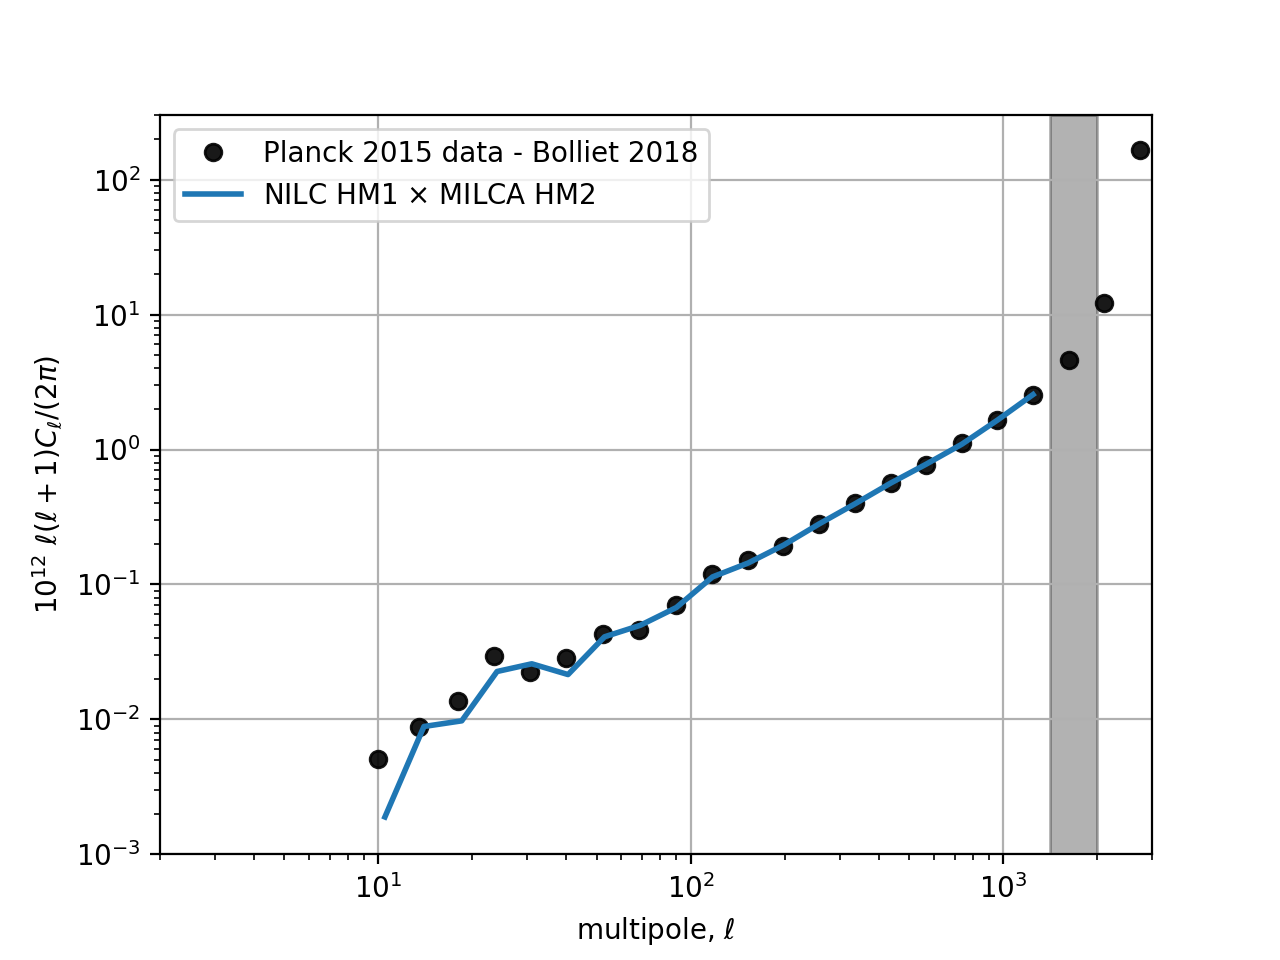

In [20]:
lbin,m_nilc_milca_tot=mtot.return_bmcs(nilc_milca_tot)
lbin,m_nilc_hm1_tot=mtot.return_bmcs(nilc_hm1_tot)
lbin,m_milca_hm2_tot=mtot.return_bmcs(milca_hm2_tot)
#lbin,m_nilc_tot=mtot.return_bmcs(nilc_tot)
#lbin,m_milca_tot=mtot.return_bmcs(milca_tot)


ell=arange(lmax+1)
bl=h.gauss_beam(fwhm=(10./60.)*pi/180.,lmax=lmax)
pwc=h.pixwin(nside)[:lmax+1]
bl=bl*pwc
fl=ell*(ell+1)*1e12/(2.*pi)/bl/bl

figure()
plot(planck_yy[:,0],planck_yy[:,1],"ko",lw=2,label="Planck 2015 data - Bolliet 2018",alpha=0.9,ms=6)
plot(lbin,m_nilc_milca_tot*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2")
#plot(lbin,m_nilc_tot*1e12,lw=2,label=r"NILC : HM1 $\times$ HM2")
#plot(lbin,m_milca_tot*1e12,lw=2,label=r"MILCA : HM1 $\times$ HM2")
#plot(d[:,0],d[:,2],"r-",lw=2,label="Planck 2015 best fit")
#plot(d[:,0],d[:,1],"k-o",lw=2,label="Planck 2015 data",alpha=0.7)


loglog()
legend(loc=0)
grid()
xlim(2,3e3)
ylim(1e-3,3e2)
#ylim(2e-4,4)
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
axvspan(1411,2000,color="k",alpha=0.3)
figname=figpath + "yy_power_spectrum_gal_ps_mask.pdf"
savefig(figname,bbox_inches="tight")

## Galactic mask + point source mask + cluster mask

<IPython.core.display.Javascript object>


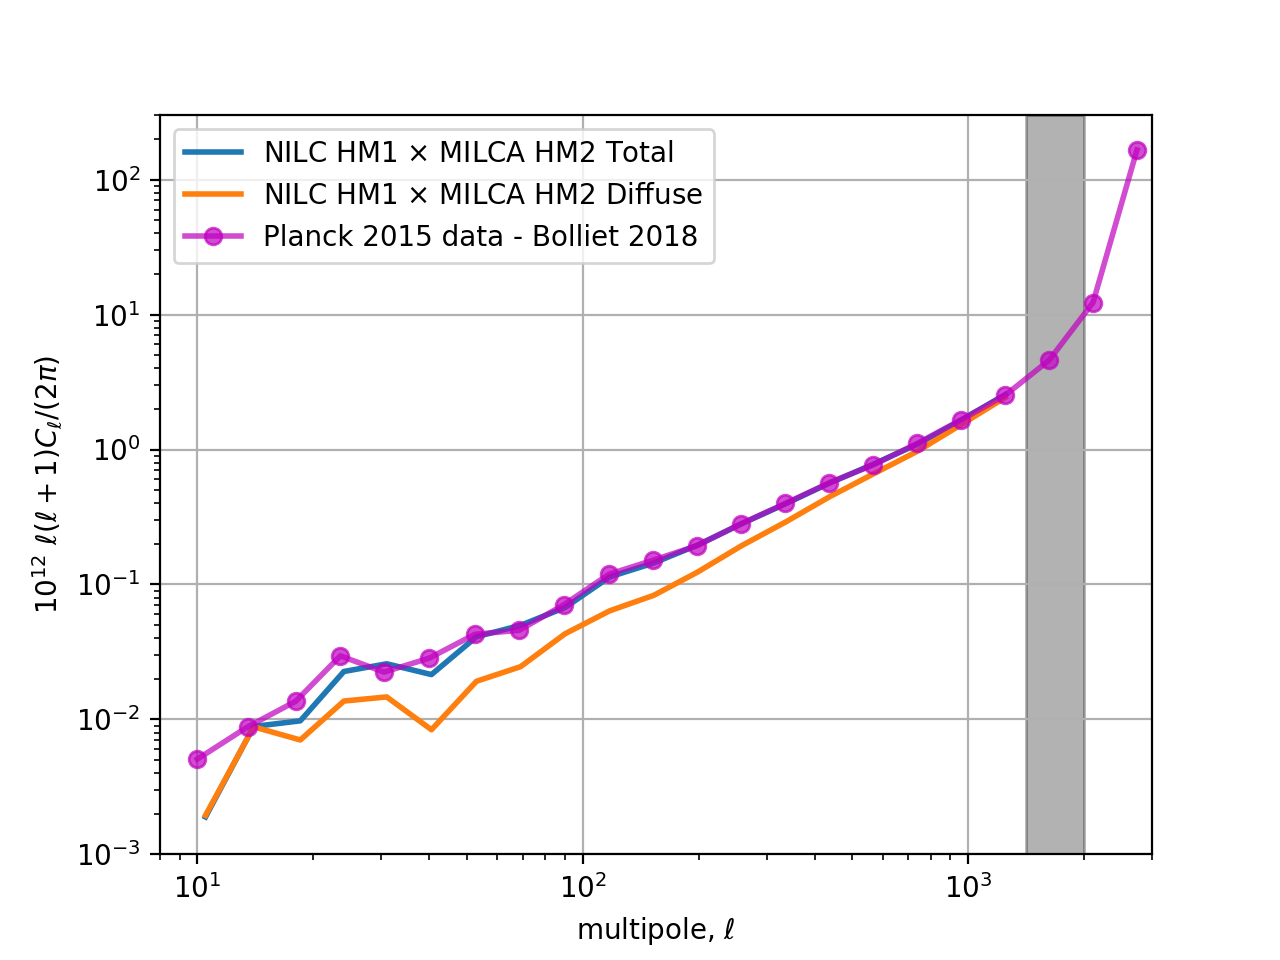

<IPython.core.display.Javascript object>


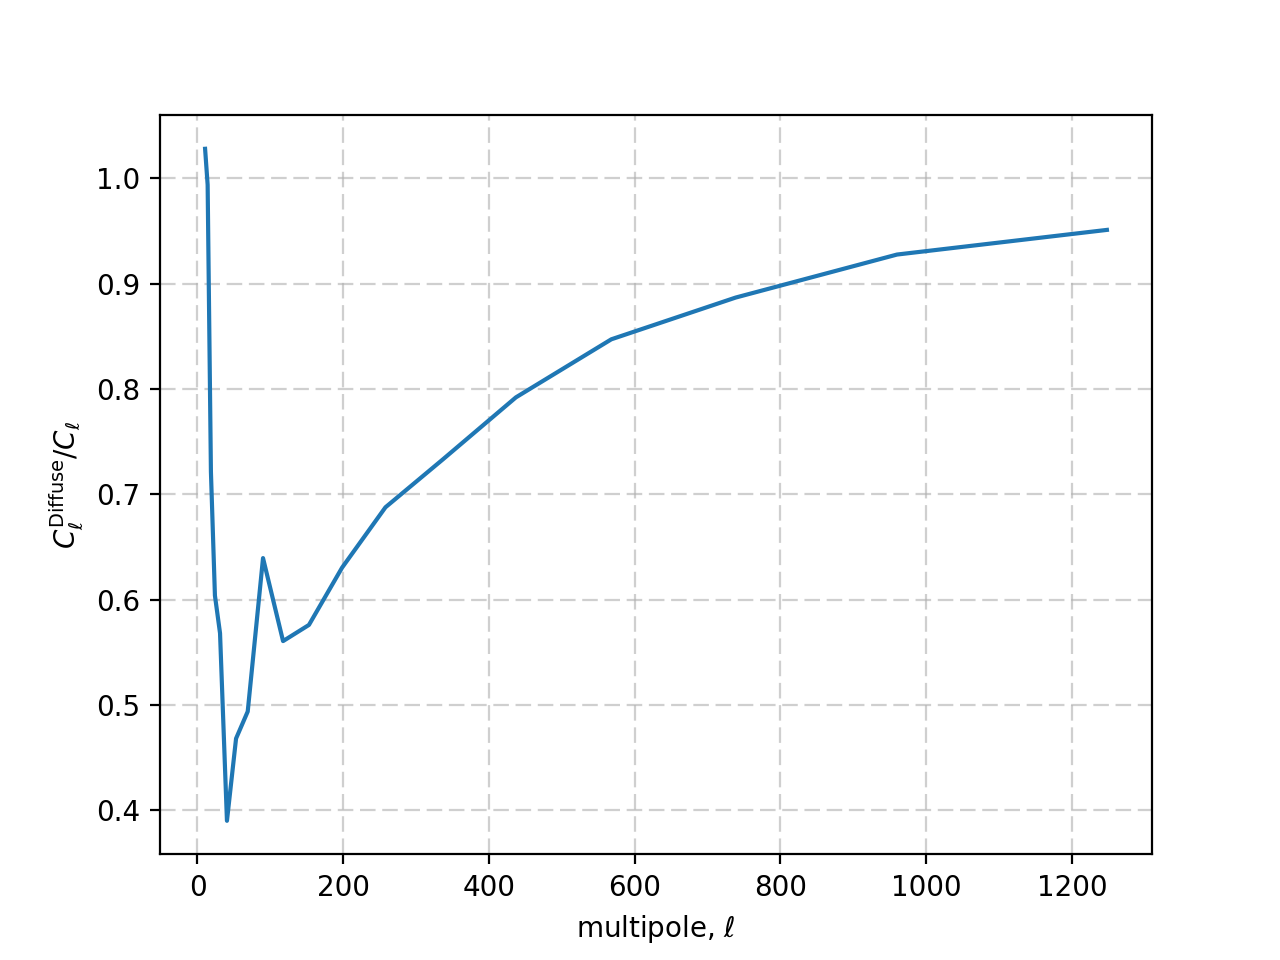

In [21]:
lbin,m_nilc_milca_diff=mdiff.return_bmcs(nilc_milca_diff)
lbin,m_nilc_hm1_diff=mdiff.return_bmcs(nilc_hm1_diff)
lbin,m_milca_hm2_diff=mdiff.return_bmcs(milca_hm2_diff)
#lbin,m_nilc_diff=mdiff.return_bmcs(nilc_diff)
#lbin,m_milca_diff=mdiff.return_bmcs(milca_diff)

figure()
plot(lbin,m_nilc_milca_tot*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2 Total")
plot(lbin,m_nilc_milca_diff*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2 Diffuse")
#plot(d[:,0],d[:,2],"r-",label="Planck 2015 best fit")
#plot(d[:,0],d[:,1],"k-o",label="Planck 2015 data",alpha=0.7)
plot(planck_yy[:,0],planck_yy[:,1],"m-o",lw=2,label="Planck 2015 data - Bolliet 2018",alpha=0.7)
loglog()
legend(loc=0)
grid()
#xlim(8,3e3)
#ylim(4e-3,3e2)
xlim(8,3e3)
ylim(1e-3,3e2)
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
axvspan(1411,2000,color="k",alpha=0.3)
figname=figpath + "yy_power_spectrum_compare_diffuse_vs_total.pdf"
savefig(figname,bbox_inches="tight")

figure()
plot(lbin,m_nilc_milca_diff/m_nilc_milca_tot)
xlabel(r"multipole, $\ell$")
ylabel(r"$C^{\rm Diffuse}_{\ell}/C_{\ell}$")
grid(alpha=0.6,linestyle="dashed")
figname=figpath + "ratio_cldiffuse_by_cltotal.pdf"
savefig(figname,bbox_inches="tight")

## Galactic mask + point source mask + cluster mask complement

<IPython.core.display.Javascript object>


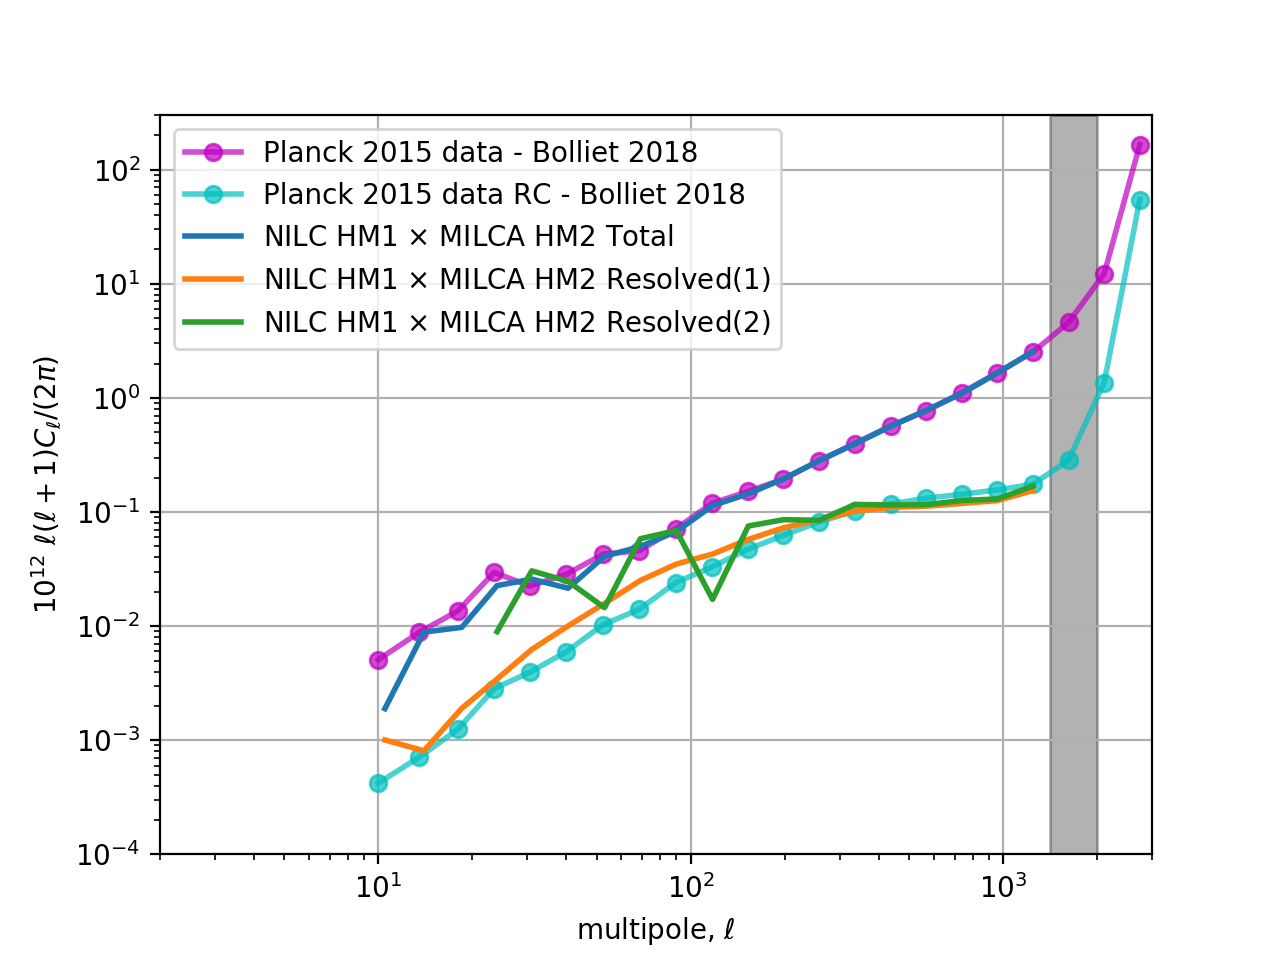

<IPython.core.display.Javascript object>


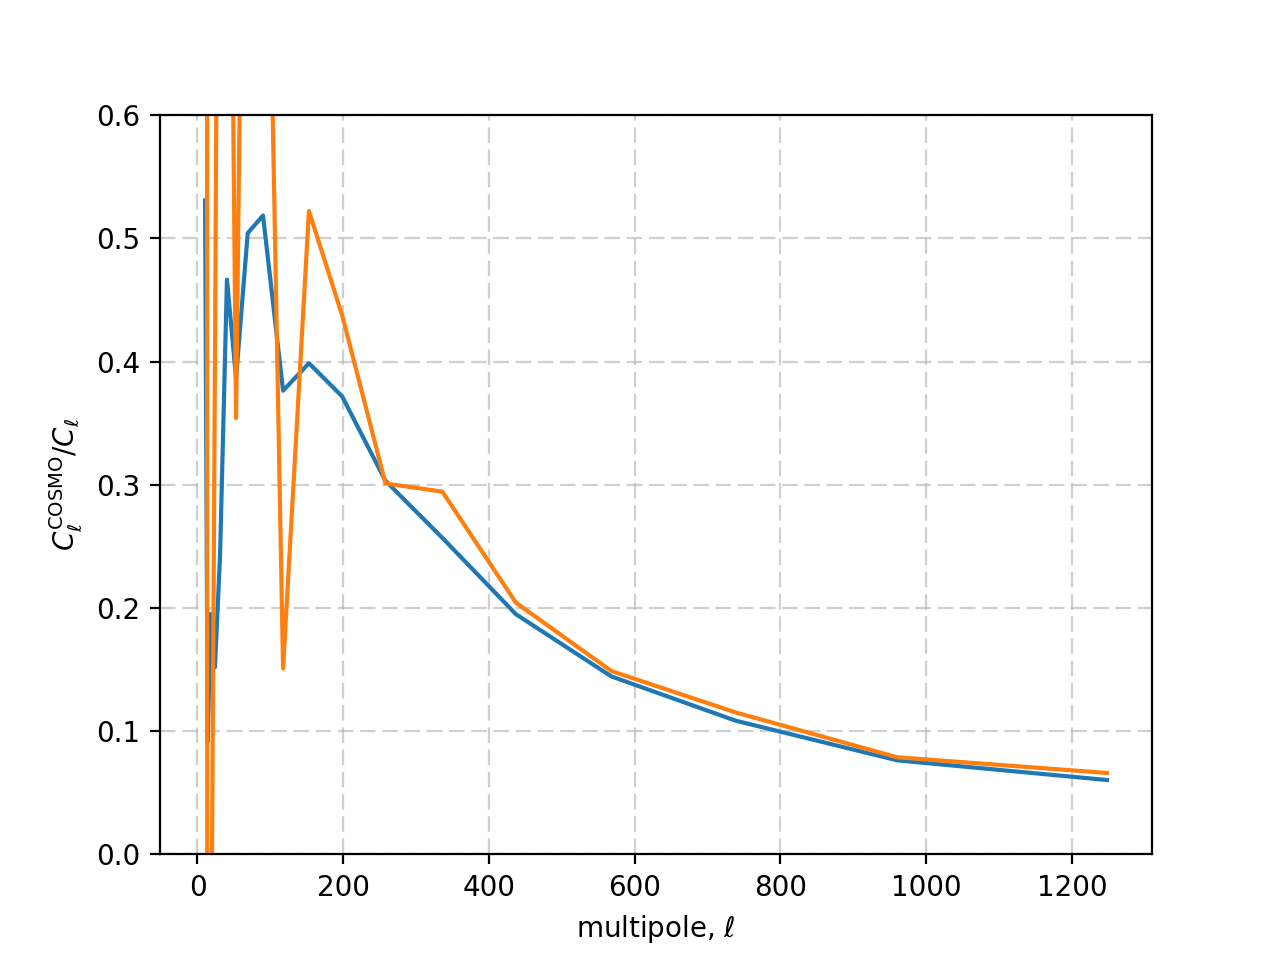

In [29]:
lbin,m_nilc_milca_res=mtot.return_bmcs(nilc_milca_res)
lbin,m_nilc_hm1_res=mtot.return_bmcs(nilc_hm1_res)
lbin,m_nilc_milca_res1=mres.return_bmcs(nilc_milca_res)
m_nilc_milca_res1=m_nilc_milca_res1*sum(gal_ps_ccl_mask)/sum(gal_ps_mask)
lbin,m_milca_hm2_res=mtot.return_bmcs(milca_hm2_res)
#lbin,m_nilc_res=mres.return_bmcs(nilc_res)
#lbin,m_milca_res=mres.return_bmcs(milca_res)


tmpell=arange(lmax+1)
figure()
plot(planck_yy[:,0],planck_yy[:,1],"m-o",lw=2,label="Planck 2015 data - Bolliet 2018",alpha=0.7)
plot(planck_yy[:,0],planck_yy[:,3],"c-o",lw=2,label="Planck 2015 data RC - Bolliet 2018",alpha=0.7)
plot(lbin,m_nilc_milca_tot*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2 Total")
plot(lbin,m_nilc_milca_res*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2 Resolved(1)")
plot(lbin,m_nilc_milca_res1*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2 Resolved(2)")
# plot(lbin,m_milca_hm2_res*1e12)
# plot(lbin,m_nilc_hm1_res*1e12)
#plot(tmpell,tmpell*(tmpell+1.)*nilc_milca_res*1e12/(2.*pi*fsky_tot*beam*beam))
loglog()
legend(loc=0)
grid()
#semilogx()
xlim(2,3e3)
#ylim(1e-4,50)
ylim(1e-4,3e2)
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
axvspan(1411,2000,color="k",alpha=0.3)
figname=figpath + "yy_power_spectrum_compare_cosmo_vs_total.pdf"
savefig(figname,bbox_inches="tight")

figure()
plot(lbin,m_nilc_milca_res/m_nilc_milca_tot)
plot(lbin,m_nilc_milca_res1/m_nilc_milca_tot)
xlabel(r"multipole, $\ell$")
ylabel(r"$C^{\rm COSMO}_{\ell}/C_{\ell}$")
grid(alpha=0.6,linestyle="dashed")
ylim(0,0.6)

figname=figpath + "ratio_clresolved_by_cltotal.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


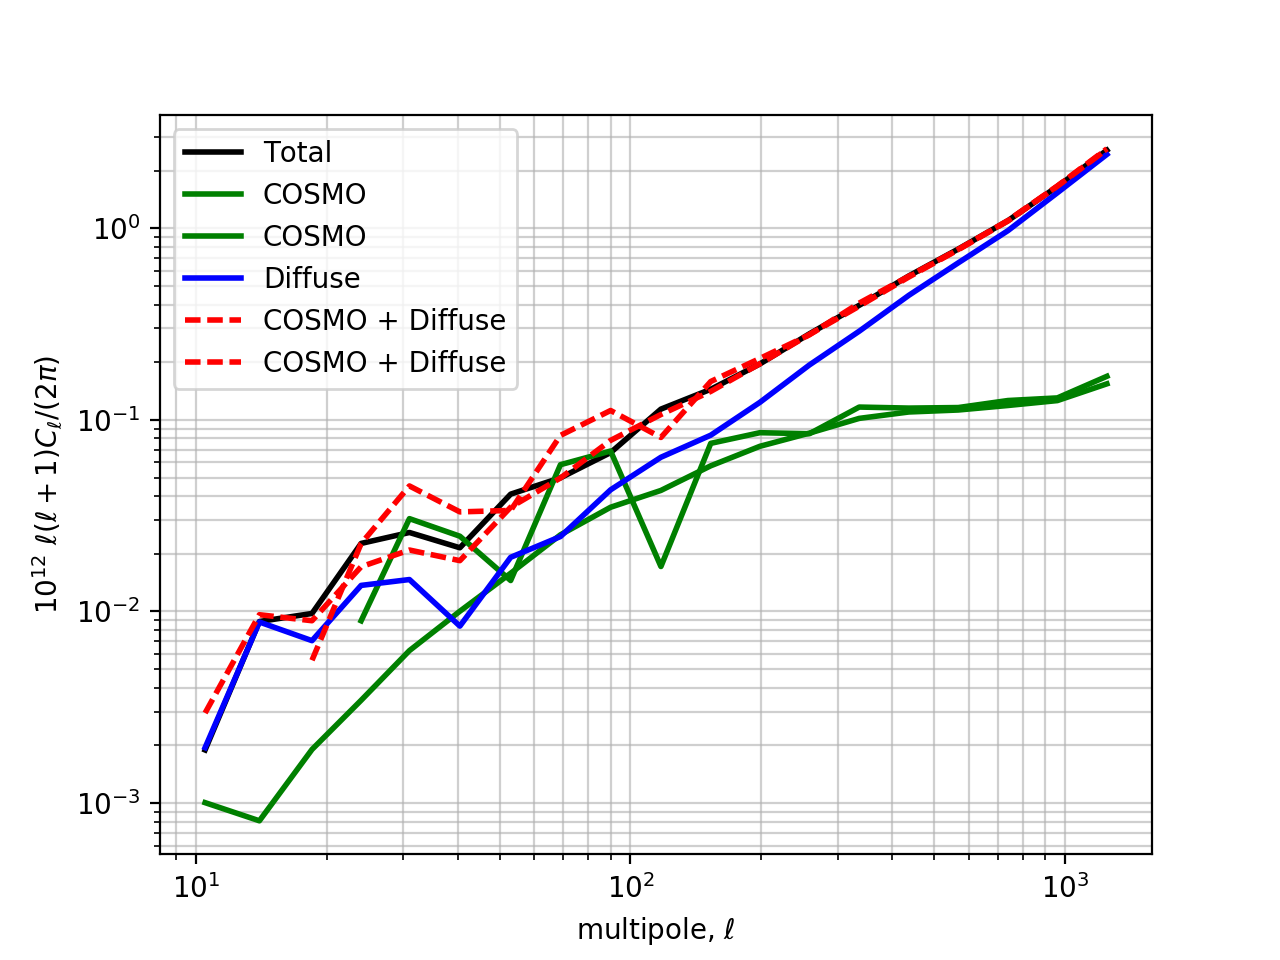

<IPython.core.display.Javascript object>


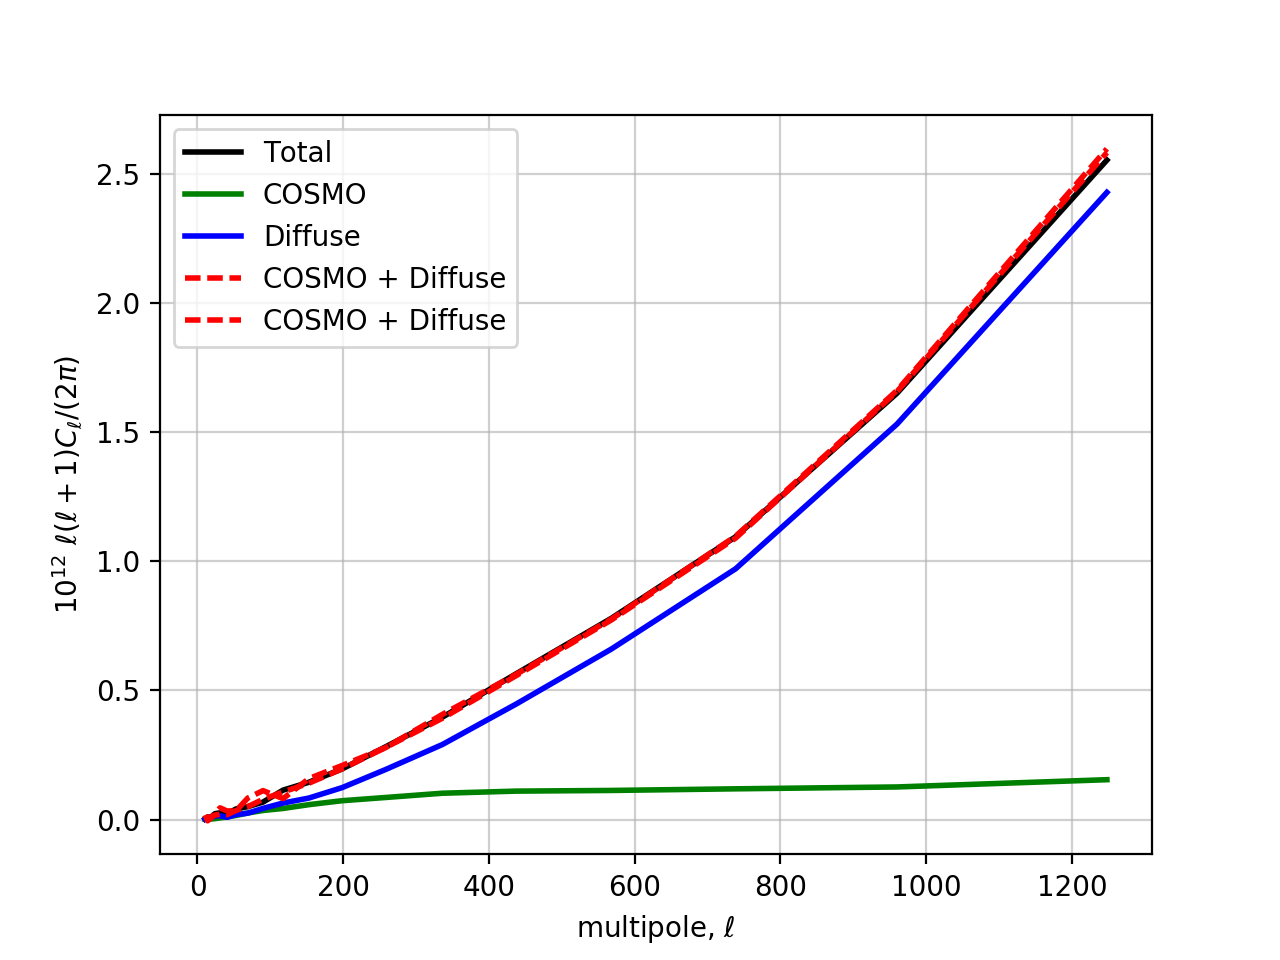

In [32]:
figure()
plot(lbin,m_nilc_milca_tot*1e12,"k-",lw=2,label=r"Total")
plot(lbin,m_nilc_milca_res*1e12,"g-",lw=2,label=r"COSMO")
plot(lbin,m_nilc_milca_res1*1e12,"g-",lw=2,label=r"COSMO")
plot(lbin,m_nilc_milca_diff*1e12,"b-",lw=2,label=r"Diffuse")
plot(lbin,(m_nilc_milca_res+m_nilc_milca_diff)*1e12,"r--",lw=2,label=r"COSMO + Diffuse")
plot(lbin,(m_nilc_milca_res1+m_nilc_milca_diff)*1e12,"r--",lw=2,label=r"COSMO + Diffuse")
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
grid(which="both",alpha=0.6,linestyle="solid")
legend(loc=0)
loglog()
figname=figpath + "test_spectra_additive.pdf"
savefig(figname,bbox_inches="tight")

figure()
plot(lbin,m_nilc_milca_tot*1e12,"k-",lw=2,label=r"Total")
plot(lbin,m_nilc_milca_res*1e12,"g-",lw=2,label=r"COSMO")
plot(lbin,m_nilc_milca_diff*1e12,"b-",lw=2,label=r"Diffuse")
plot(lbin,(m_nilc_milca_res+m_nilc_milca_diff)*1e12,"r--",lw=2,label=r"COSMO + Diffuse")
plot(lbin,(m_nilc_milca_res1+m_nilc_milca_diff)*1e12,"r--",lw=2,label=r"COSMO + Diffuse")
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
grid(which="both",alpha=0.6,linestyle="solid")
legend(loc=0)
#semilogx()
#ylim(0,0.05)
figname=figpath + "test_spectra_additive_linear.pdf"
savefig(figname,bbox_inches="tight")

In [ ]:
figure()
plot(lbin,m_nilc_milca_diff/m_nilc_milca_tot,"b.-",lw=2,label=r"$C^{\rm uRC}_{\ell}/C^{\rm Total}_{\ell}$")
plot(lbin,m_nilc_milca_res/m_nilc_milca_tot,"r.-",lw=2,label=r"$C^{\rm RC}_{\ell}/C^{\rm Total}_{\ell}$")
plot(lbin,m_nilc_milca_res1/m_nilc_milca_tot,"r--",lw=2,label=r"$C^{\rm RC}_{\ell}/C^{\rm Total}_{\ell}$")
plot(lbin,(m_nilc_milca_diff + m_nilc_milca_res)/m_nilc_milca_tot,"k.-",lw=2,label=r"$(C^{\rm RC}_{\ell} + C^{\rm uRC}_{\ell})/C^{\rm Total}_{\ell}$")
axhline(1.,ls="dashed",c="k")
xlabel(r"multipole, $\ell$")
ylabel("Ratio of yy-power spectrum")
legend(loc=0)
grid(alpha=0.6,linestyle="dashed")
figname=figpath + "ratio_of_power_in_y.pdf"
semilogx()
savefig(figname,bbox_inches="tight")

In [ ]:
tmpell=arange(lmax+1)
figure()
plot(lbin,m_nilc_milca_tot*1e12,"k-",lw=2,label=r"Total")
plot(lbin,m_nilc_milca_diff*1e12,"b-",lw=2,label=r"uRC")
plot(lbin,m_nilc_milca_res*1e12,"r-",lw=2,label=r"RC")
plot(planck_yy[:,0],planck_yy[:,1],"m-o",lw=2,label="Planck 2015 data",alpha=0.5)
plot(planck_yy[:,0],planck_yy[:,3],"c-o",lw=2,label="Planck 2015 data RC (simulated)",alpha=0.5)
#plot(lbin,m_nilc_milca_diff*1e12 + m_nilc_milca_res*1e12,"r--",lw=2,label=r"uRC + RC")

loglog()
legend(loc=0)
grid(which="both",linestyle="dashed",alpha=0.6)
#semilogx()
xlim(9,2e3)
#ylim(1e-4,50)
ylim(2e-4,2e1)
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
axvspan(1411,2000,color="k",alpha=0.3)
figname=figpath + "yy_power_spectrum_compare.pdf"
savefig(figname,bbox_inches="tight")

# Error estimation

In [ ]:
err_tot=(1./((2.*lbin+1.)*mtot.deltaell_bin*fsky_tot_apo))
err_tot=1e12*np.sqrt(err_tot*(m_milca_hm2_tot*m_nilc_hm1_tot + m_nilc_milca_tot**2.))

# err=(1./((2.*lbin+1.)*mtot.deltaell_bin*fsky_tot_apo))
# err=1e12*np.sqrt(err*(2.*m_nilc_milca_tot**2.))

err_diff=(1./((2.*lbin+1.)*mdiff.deltaell_bin*fsky_diff_apo))
err_diff=1e12*np.sqrt(err_diff*(m_milca_hm2_diff*m_nilc_hm1_diff + m_nilc_milca_diff**2.))

err_res=(1./((2.*lbin+1.)*mdiff.deltaell_bin*fsky_tot_apo))
err_res=1e12*np.sqrt(err_res*(m_milca_hm2_res*m_nilc_hm1_res + m_nilc_milca_res**2.))

figure()

plot(lbin,err_tot,"k-",lw=2,label="Total")
plot(lbin,err_diff,"b-",lw=2,label="uRC")
plot(lbin,err_res,"r-",lw=2,label="RC")
#plot(lbin,err,lw=2,label="Signal CV")
#plot(lbin,m_nilc_milca_tot*1e12,lw=2,label="Signal")
#plot(lbin,np.sqrt(err_res**2. + err_diff**2.),lw=2,label="Diffuse + Resolved (added in quadrature)")
plot(planck_yy[:,0],planck_yy[:,2],"m--",lw=2,label="Planck 2015 data",alpha=0.6)
plot(planck_yy[:19,0],planck_yy[:19,2]-err_tot,"g--",label="|Planck 2015 data - Total|")
xlabel(r"multipole, $\ell$")
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)\sigma_{C_{\ell}}/(2 \pi)$")
grid(alpha=0.6,linestyle="dashed",which="both")
loglog()
ylim(1e-4,5e-1)
xlim(9,2e3)
#ylim(2e-4,2e1)
legend(loc=0,fontsize=9)
figname=figpath + "error_estimates.pdf"
savefig(figname,bbox_inches="tight")

# Write data

In [ ]:
filename=dataout_path + "total_yy_spec.txt"
title_str="# Total yy-spectrum"
fsky_str="# fsky=" + str(round(fsky_tot,3)) + " ; effective_fsky=" + str(round(fsky_tot_apo,3))
f=open(filename,"wb")
f.write("%-s \n" % title_str)
f.write("%-s \n" % "# Flags: SNR>=0. & COSMO=F ")
f.write("%-s \n \n" % fsky_str)
f.write("%-15s %-15s %-15s %-15s %-15s \n \n" % ("# lmin","lmax", "ell_eff","Dlyy*1e12","err_Dlyy*1e12 (Gauss)"))
for i in range(np.size(lbin)):
    f.write("%-15.8f %-15.8f %-15.8f %-15.8f %-15.8f\n" % (mtot.bmin[i],mtot.bmax[i],lbin[i],m_nilc_milca_tot[i]*1e12,err_tot[i]))
f.close()
tot=loadtxt(filename)

filename=dataout_path + "unresolved_yy_spec.txt"
title_str="# Un-resolved yy-spectrum"
fsky_str="# fsky=" + str(round(fsky_diff,3)) + " ; effective_fsky=" + str(round(fsky_diff_apo,3))
f=open(filename,"wb")
f.write("%-s \n" % title_str)
f.write("%-s \n" % "# Flags: COMPLEMENT(SNR>=6. & COSMO=T)")
f.write("%-s \n \n" % fsky_str)
f.write("%-15s %-15s %-15s %-15s %-15s \n \n" % ("# lmin", "lmax", "ell_eff","Dlyy*1e12","err_Dlyy*1e12 (Gauss)"))
for i in range(np.size(lbin)):
    f.write("%-15.8f %-15.8f %-15.8f %-15.8f %-15.8f\n" % (mtot.bmin[i],mtot.bmax[i],lbin[i],m_nilc_milca_diff[i]*1e12,err_diff[i]))
f.close()
diff=loadtxt(filename)

filename=dataout_path + "resolved_yy_spec.txt"
title_str="# Resolved yy-spectrum"
fsky_str="# fsky=" + str(round(fsky_tot,3)) + " ; effective_fsky=" + str(round(fsky_tot_apo,3))
f=open(filename,"wb")
f.write("%-s \n" % title_str)
f.write("%-s \n" % "# Flags: (SNR>=6. & COSMO=T)")
f.write("%-s \n \n" % fsky_str)
f.write("%-15s %-15s %-15s %-15s %-15s \n \n" % ("# lmin", "lmax", "ell_eff","Dlyy*1e12","err_Dlyy*1e12 (Gauss)"))
for i in range(np.size(lbin)):
    f.write("%-15.8f %-15.8f %-15.8f %-15.8f %-15.8f\n" % (mtot.bmin[i],mtot.bmax[i],lbin[i],m_nilc_milca_res[i]*1e12,err_res[i]))
f.close()
res=loadtxt(filename)

In [ ]:
figure()
plot(lbin,res[:,3])
plot(lbin,m_nilc_milca_res*1e12,"--")

figure()
plot(lbin,diff[:,4])
plot(lbin,err_diff,"--")
loglog()

# Test master algorithm

<IPython.core.display.Javascript object>


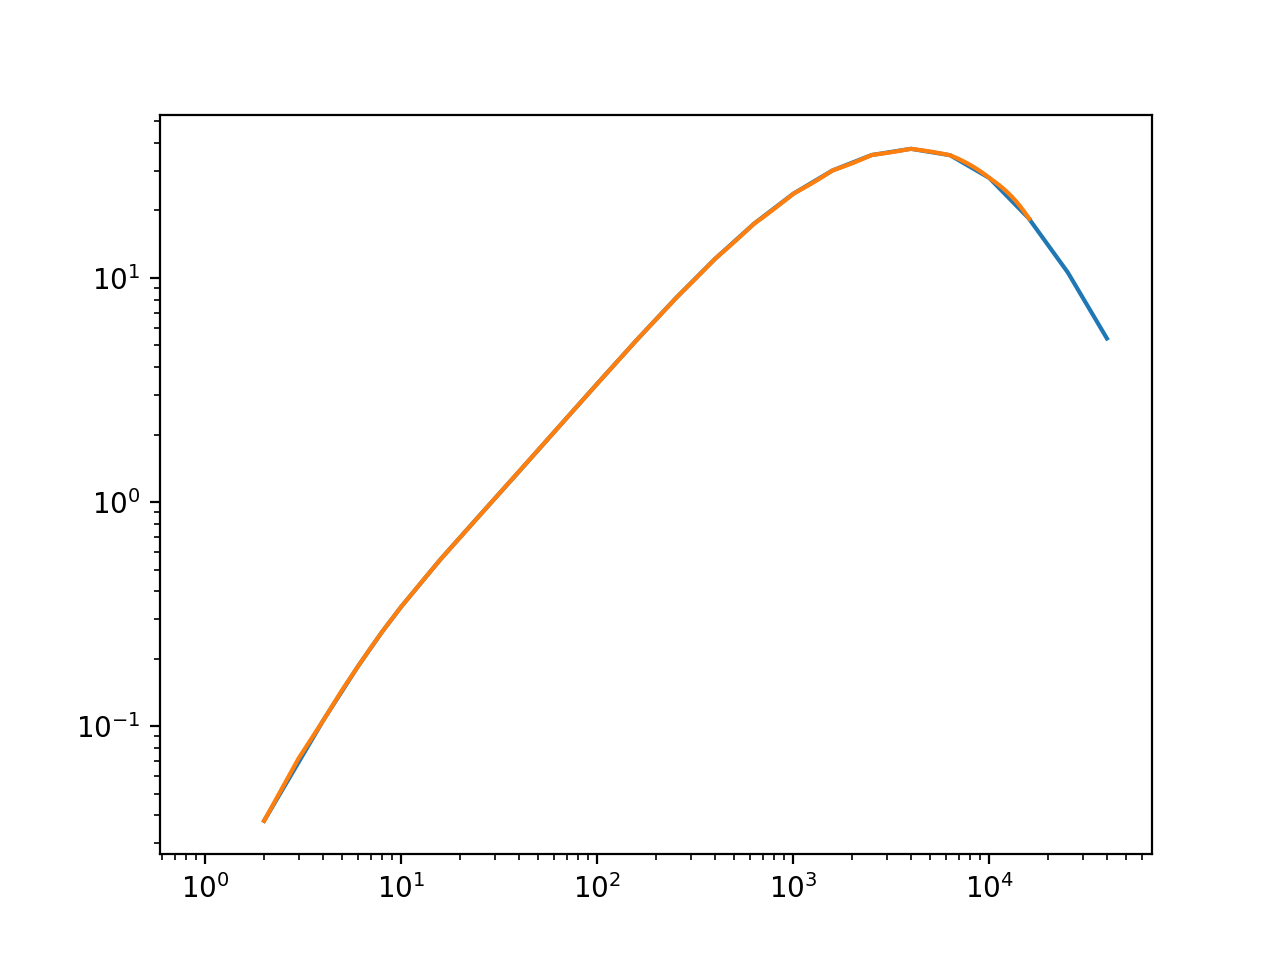

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [22]:
from scipy.interpolate import interp1d
d=loadtxt(datapath + "/spectra/multipole_szpower_1e11_5e16.txt")
fn=interp1d(d[:,0],d[:,1])
ell=arange(15999,dtype="float") ; ell=ell+2.
clyy=fn(ell)
clyy=clyy*2.*pi/(ell*(ell+1.))
clyy=append(np.zeros(2,float),clyy)
ell=append(arange(2,dtype="float"),ell)

figure()
plot(d[:,0],d[:,1])
plot(ell,ell*(ell+1)*clyy/(2.*pi))
loglog()

beam=h.gauss_beam(fwhm=(10./60.)*pi/180.,lmax=2000)*h.pixwin(nside)[:2001]
alm=h.synalm(clyy,lmax=2000,new=True) ; alm=h.almxfl(alm,beam)
sim_map=h.alm2map(alm,nside)

In [20]:
tmask=gal_ps_ccl_mask ; fsky_res=sum(tmask)/size(tmask)
simcl_res=h.alm2cl(h.map2alm(sim_map*tmask,lmax=lmax))
lbin,m_simcl_res=mres.return_bmcs(simcl_res)

tmask=gal_ps_cl_mask ; fsky_diff=sum(tmask)/size(tmask)
simcl_diff=h.alm2cl(h.map2alm(sim_map*tmask,lmax=lmax))
lbin,m_simcl_diff=mdiff.return_bmcs(simcl_diff)

In [ ]:
h.orthview(sim_map*gal_ps_ccl_mask ,rot=(0,90),min=-5,max=5,title=r"Simulated y-map $(f_{\rm sky}=" + str(round(fsky_res,3)) + ")$")
figname=figpath + "sim_masked_y_res.pdf"
savefig(figname,bbox_inches="tight")

h.orthview(sim_map*gal_ps_cl_mask ,rot=(0,90),min=-5,max=5,title=r"Simulated y-map $(f_{\rm sky}=" + str(round(fsky_diff,3)) + ")$")
figname=figpath + "sim_masked_y_diff.pdf"
savefig(figname,bbox_inches="tight")

ell=arange(lmax+1)
figure()
plot(ell,ell*(ell+1)*simcl_res[:lmax+1]/(2.*pi*fsky_res*bl[:lmax+1]*bl[:lmax+1]),alpha=0.8,label=r"$f_{sky}$ corrected spectrum")
plot(ell,ell*(ell+1)*clyy[:lmax+1]/(2.*pi),"k-",lw=2,label="True spectrum")
plot(lbin,m_simcl_res,"r-.",label="Master corrected spectrum")
legend(loc=0)
grid(alpha=0.6,linestyle="dashed")
xlabel("multipole, $\ell$")
ylabel(r"$\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlim(8,1500)
ylim(4e-3,35)
semilogx()
#loglog()
figname=figpath + "sim_cl_yy_res.pdf"
loglog()
savefig(figname,bbox_inches="tight")

ell=arange(lmax+1)
figure()
plot(ell,ell*(ell+1)*simcl_diff[:lmax+1]/(2.*pi*fsky_diff*bl[:lmax+1]*bl[:lmax+1]),alpha=0.8,label=r"$f_{sky}$ corrected spectrum")
plot(ell,ell*(ell+1)*clyy[:lmax+1]/(2.*pi),"k-",lw=2,label="True spectrum")
plot(lbin,m_simcl_diff,"r-.",label="Master corrected spectrum")
legend(loc=0)
grid(alpha=0.6,linestyle="dashed")
xlabel("multipole, $\ell$")
ylabel(r"$\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlim(8,1500)
ylim(4e-3,35)
semilogx()
#loglog()
figname=figpath + "sim_cl_yy_diff.pdf"
loglog()
savefig(figname,bbox_inches="tight")

figure()
imshow(log10(mres.mbbp),origin="lower")
xlabel("multipole, $\ell$")
ylabel("multipole, $\ell'$")
colorbar()
xticks(linspace(0,size(lbin)-1,5),linspace(2,lmax,5))
yticks(linspace(0,size(lbin)-1,5),linspace(2,lmax,5))
figname=figpath + "coupling_matrix_resolved_cluster_mask.pdf"
savefig(figname,bbox_inches="tight")

figure()
imshow(log10(mdiff.mbbp),origin="lower")
xlabel("multipole, $\ell$")
ylabel("multipole, $\ell'$")
colorbar()
xticks(linspace(0,size(lbin)-1,5),linspace(2,lmax,5))
yticks(linspace(0,size(lbin)-1,5),linspace(2,lmax,5))
figname=figpath + "coupling_matrix_diffuse_cluster_mask.pdf"
savefig(figname,bbox_inches="tight")

# Theory

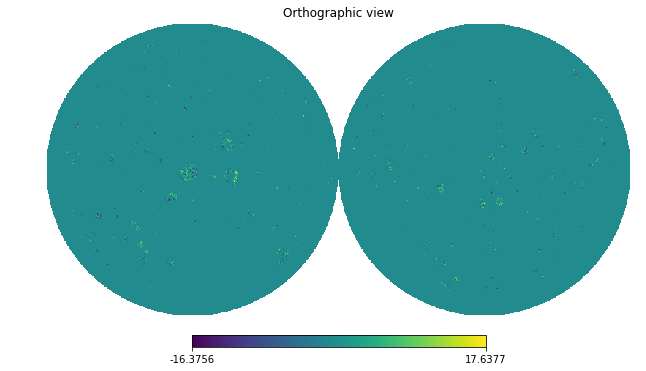

In [54]:
# h.orthview(gal_ps_ccl_mask*tmap,rot=(0,90))

In [188]:
# dtot=loadtxt("../../../../Paper_plots/relativistic_sz/clyy/multipole_szpower_1e11_5e15.txt")
# dhm=loadtxt("../../../../Paper_plots/relativistic_sz/clyy/multipole_szpower_5e14_5e15.txt")

<IPython.core.display.Javascript object>


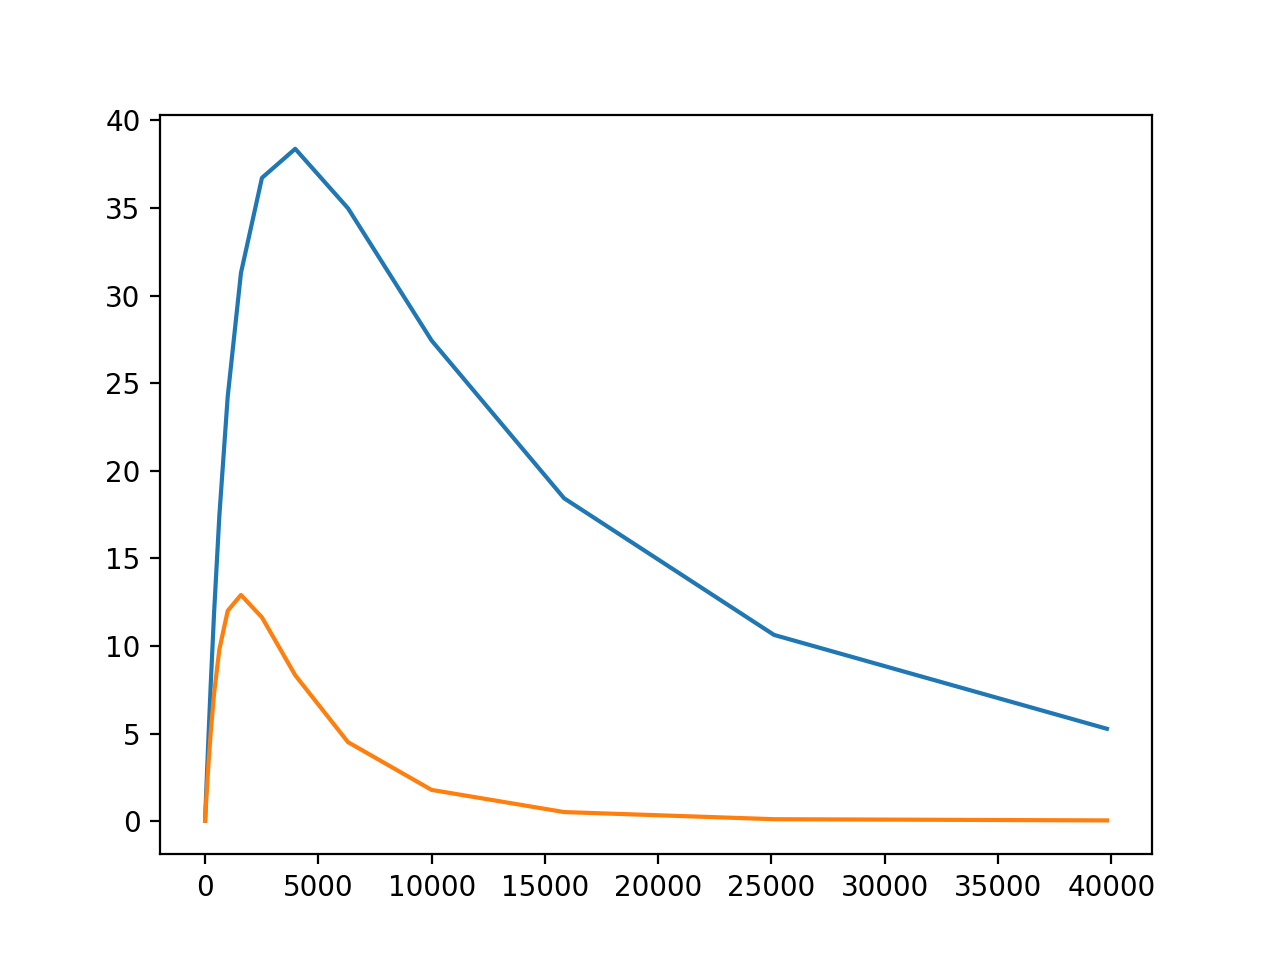

<IPython.core.display.Javascript object>


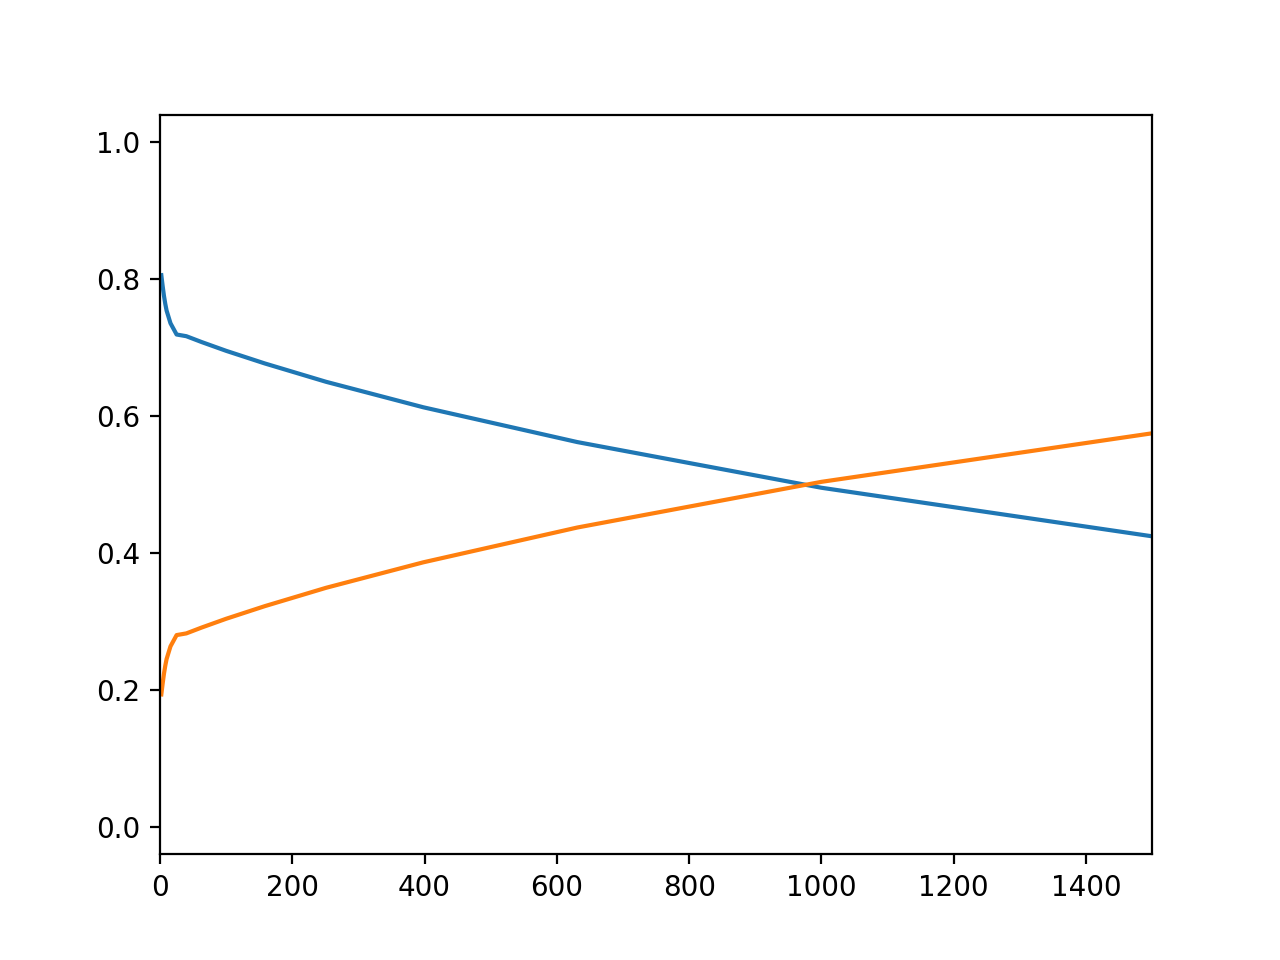

(0, 1500)

In [194]:
# figure()
# plot(dtot[:,0],dtot[:,1])
# plot(dhm[:,0],dhm[:,1])

# figure()
# plot(dhm[:,0],dhm[:,1]/dtot[:,1])
# plot(dhm[:,0],(dtot[:,1]-dhm[:,1])/dtot[:,1])
# xlim(0,1500)